# **Pankow Library Dataset 2022**

# 1. Overview

The dataset analyzed in this notebook comprises over 1.5 million individual library transaction records from 2022 from the eight libraries in Berlin's Pankow district:

<ol style="margin-bottom: 1em;"> 
  <li> Janusz-Korczak-Bibliothek</li>
  <li> Wolfdietrich-Schnurre-Bibliothek</li>
  <li> Bettina-von-Arnim-Bibliothek</li>
  <li> Bibliothek Am Wasserturm</li>
  <li> Heinrich-Böll-Bibliothek</li>
  <li> Kurt-Tucholsky-Bibliothek</li>
  <li> Stadtteilbibliothek Buch-Karow (Karow)</li>
  <li> Stadtteilbibliothek Buch-Karow (Buch)</li>
</ol> 

The analysis focuses solely on borrowing transactions, excluding renewals. While the first part of the notebook (Chapter 2) explores and describes the dataset, the second part (Chapter 3) adopts a more interpretative approach, seeking possible explanations for users’ disengagement with library services during adolescence.

You can download the dataset from the [Berlin City Open Data Portal](https://daten.berlin.de/datensaetze/ausleihen-in-offentlichen-bibliotheken-in-pankow-2022).

A dashboard published by Pankow libraries is also available [here](https://grafana.odis-berlin.de/public-dashboards/6b18fd27a9f84f959a4f63cfe0b985be?orgId=1).



Written by Friedemann Schwenzer

## 1.1. List of Tables 


* <u>Table 1</u> Sample of Cleaned and Translated Dataset
* <u>Table 2</u> Dataset Information
* <u>Table 3</u> Missing Values by Attribute
* <u>Table 4</u> Borrowings by Title (Top 5)
* <u>Table 5</u> Borrowings by Author (Top 5)
* <u>Table 6</u> Borrowings by Media Type: Frequency Table
* <u>Table 7</u> Borrowings by Genre: Frequency Table
* <u>Table 8</u> Borrowings by User Groups: Frequency Table
* <u>Table 9</u> Borrowings by Gender: Frequency Table
* <u>Table 10</u> Borrowings by Age Groups: Frequency Table (sorted)
* <u>Table 11</u> Borrowings by Target Group: Frequency Table
* <u>Table 12</u> Borrowings by Month: Frequency Table (sorted)
* <u>Table 13</u> Borrowings by Library: Frequency Table
* <u>Table 14</u> Cramér’s V Matrix
* <u>Table 15</u> Borrowings by Age and Target Groups: Frequency Table
* <u>Table 16</u> Age Group Breakdown of Borrowed Items for the Target Group “Children”
* <u>Table 17</u> Borrowings by Age Group and Gender (binary)

## 1.2. List of Figures 

* <u>Figure 1</u> Missing Values per Attribute: Relative Frequencies
* <u>Figure 2</u> Borrowings by Media Type: Relative Frequencies
* <u>Figure 3</u> Borrowings by User Groups: Relative Frequencies
* <u>Figure 4</u> Borrowings by Gender: Relative Frequencies
* <u>Figure 5</u> Age Groups: Relative Frequencies
* <u>Figure 6</u> Target Group: Relative Frequencies
* <u>Figure 7</u> Borrowings by Month: Relative Frequencies
* <u>Figure 8</u> Borrowings by Library: Relative Frequencies
* <u>Figure 9</u> Cramér’s V Heatmap
* <u>Figure 10</u> Age Group Breakdown of Borrowed Items for the Target Group “Children”
* <u>Figure 11</u> Number Borrowings by Target Groups
* <u>Figure 12</u> Borrowings by Age Group and Gender (binary)
* <u>Figure 13</u> Borrowings by Age Group and Gender: Relative Frequencies
* <u>Figure 14-22</u> Borrowings by Age Group and Libraries: Relative Frequencies
* <u>Figure 22-30</u> Borrowings by Age Group and Libraries 

# 2. Exploratory Data Analysis 

## 2.1. Preparing the Notebook

In [195]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

## 2.2. Reading in the Data 

In [ ]:
 data_raw = pd.read_csv("/Users/Friedemann/Desktop/AusEx_Pankow_2022.csv")


## 2.3. Creating a Tidy and Translated Subset for Borrowing Transactions Only 

In [194]:
#defining the columns to be translated as variable
rename_cols = {"Titel": "Title","Autor:in": "Author","Medientypcode": "Media Type","Fächerstatistik": "Genre" ,"Benutzergruppe": "User Group","Geschlecht": "Gender","Altersgruppe": "Age Group", "Fächerstatistik2": "Target Group", "Monat": "Month", "Sigel besitzende Bibliothek": "Library"}

#creating a data frame of the subset, selecting only "Ausleihtyp A", excluding "Medientypcode "Nicht bestellbar" and "Nicht entleihbar",  only keeping the renamed columns   

loans_df = data_raw \
	.loc[
    	(data_raw['Ausleihtyp'] == 'A') &
    	(data_raw['Medientypcode'] != 'Nicht bestellbar') &
    	(data_raw['Medientypcode'] != 'Nicht entleihbar'),
    	rename_cols.keys()
	] \
	.rename(columns=rename_cols)

#Adjusting data types 
loans_df["Media Type"] = loans_df["Media Type"].astype("category")
loans_df["Gender"] = loans_df["Gender"].astype("category")
loans_df["Genre"] = loans_df["Genre"].astype("category")
loans_df["Age Group"]= loans_df["Age Group"].astype("category")
loans_df["Target Group"] = loans_df["Target Group"].astype("category")
loans_df["User Group"] = loans_df["User Group"].astype("category")
loans_df["Month"] = loans_df["Month"].astype(int)
loans_df["Library"]= loans_df["Library"].astype("category") 

#defining media type translation as variable 
media_type_translation = {"Buch": "Book", "Medienkombination": "Media Combination","Konventionelles Spiel": "Conventional Game", "DVD": "DVD","Noten": "Sheet Music","Zeitschrift": "Magazine","CD": "CD", "Software": "Software", "Konsolenspiel": "Console Game","Mobiles Endgerät": "Mobile Device", "Verkürzte Leihfrist": "Shortened Loan Period","Sonstiges": "Other","Nur vor Ort entleihbar": "In-library use only"}

#defining gender translations as variable 
gender_translation = {"M": "Male","W": "Female","K": "No Information"}

#defining genre translations as variable
genre_translation = {"Sachliteratur": "Non-fiction","Schöne Literatur": "Fiction","Spiele": "Games","Musik": "Music"}

#defining genre translations as variable
user_group_translation = {"Schüler ab 16": "Students 16+","Erwachsene": "Adults","ermäßigte Erwachsene": "Adults (reduced rate)", "entgeltfreie Erwachsene": "Adults (no charge)", "Bibliothekspersonal": "Library Staff", "Kinder und Jugendliche": "Children and Youth", "Öffentlich-rechtliche Institution": "Public Institution", "Flüchtlinge": "Refugees", "Berliner Verwaltung": "Berlin Administration"}

#defining target group as variable
target_group_translation = {"Erwachsene": "Adults","Jugend": "Youth","Kinder": "Children"}

#defining libraries as variables 
libraries = {975: "Bibliothek Am Wasserturm",971: "Bettina-von-Arnim-Bibliothek", 650:"Wolfdietrich-Schnurre-Bibliothek", 462:"Janusz-Korczak-Bibliothek",655:"Stadtteilbibliothek Buch-Karow (Karow)", 457:"Heinrich-Böll-Bibliothek",972:"Kurt-Tucholsky-Bibliothek",471:"Stadtteilbibliothek Buch-Karow (Buch)" }

#defining genre translations as variable
month_name_map = {1: "January", 2: "February", 3: "March", 4: "April",5: "May", 6: "June", 7: "July", 8: "August",9: "September", 10: "October", 11: "November", 12: "December"}

month_order = list(month_name_map.values())

#translating "ab 80"  
loans_df["Age Group"] = loans_df["Age Group"].cat.rename_categories(
    lambda x: "80+" if x == "ab 80" else x
)

#defining age groups as variable 
age_order = ["0-5", "6-10", "11-14", "15-17", "18-24", "25-39", "40-54", "55-64", "65-79", "80+"]
loans_df["Age Group"] = pd.Categorical(loans_df["Age Group"], categories=age_order, ordered=True)

# Apply translations and categorical encoding (effectively drops null-values in respective columns) 
loans_df["Media Type"] = loans_df["Media Type"].cat.rename_categories(media_type_translation)
loans_df["Gender"] = loans_df["Gender"].cat.rename_categories(gender_translation)
loans_df["Genre"] = loans_df["Genre"].cat.rename_categories(genre_translation)
loans_df["Target Group"] = loans_df["Target Group"].cat.rename_categories(target_group_translation)
loans_df["User Group"] = loans_df["User Group"].cat.rename_categories(user_group_translation)
loans_df["Month"] = loans_df["Month"].map(month_name_map)
loans_df["Month"] = pd.Categorical(loans_df["Month"], categories=month_order, ordered=True)
loans_df["Library"]= loans_df["Library"].cat.rename_categories(libraries)


## 2.4. Generating Dataset Information & Statistics

<u>Key Takeaways</u>

* The dataset comprises 746.042 observations across 10 variables
* Of these variables, two (“Title” and “Author”) are text-based and stored as object types, while the remaining eight (“Media Type”, “Genre”, “Gender”, “User Group”, “Age Group”, “Target Group”, “Month”, and “Library”) are encoded as categorical data.
* The dataset does not contain any numerical variables
* Out of a total of 7.460.420 data cells, 151.777 are missing, corresponding to only about 2% of the dataset

### 2.4.1. Sample 

#### <u>Table 1</u> Sample of Cleaned and Translated Dataset

In [128]:
loans_df

,Title,Author,Media Type,Genre,User Group,Gender,Age Group,Target Group,Month,Library
0,Die Jahrhundertwissenschaft : Werner Heisenber...,"Hermann, Armin",Book,Non-fiction,Students 16+,Male,15-17,Adults,January,Bibliothek Am Wasserturm
3,Mein erster Polyglott - Italien und Italienisch,"Sansone, Emma",Book,Non-fiction,Adults,Female,40-54,Children,December,Bibliothek Am Wasserturm
4,Claude Monet : 1840 - 1926,"Heinrich, Christoph",Book,Non-fiction,Adults (reduced rate),Male,NaN,Adults,July,Bibliothek Am Wasserturm
5,"Persönlichkeitstheorien : Freud, Adler, Jung, ...","Pervin, Lawrence A.",Book,Non-fiction,Adults (no charge),Female,40-54,Adults,November,Bettina-von-Arnim-Bibliothek
6,"Persönlichkeitstheorien : Freud, Adler, Jung, ...","Pervin, Lawrence A.",Book,Non-fiction,Adults (no charge),Female,40-54,Adults,May,Bettina-von-Arnim-Bibliothek
...,...,...,...,...,...,...,...,...,...,...
1551123,Warum Diversity uns alle angeht : wie ich der ...,"Buschbaum, Balian",Book,Non-fiction,Adults (reduced rate),Female,40-54,Adults,November,Bettina-von-Arnim-Bibliothek
1551124,Warum Diversity uns alle angeht : wie ich der ...,"Buschbaum, Balian",Book,Non-fiction,Adults (reduced rate),Female,40-54,Adults,August,Bettina-von-Arnim-Bibliothek
1551128,1795 : Roman,"Natt och Dag, Niklas",Book,Fiction,Adults,Male,55-64,Adults,August,Bettina-von-Arnim-Bibliothek
1551129,1795 : Roman,"Natt och Dag, Niklas",Book,Fiction,Children and Youth,Male,0-5,Adults,October,Bettina-von-Arnim-Bibliothek


### 2.4.2. Dataset Information

#### <u>Table 2</u> Dataset Information

In [125]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 746042 entries, 0 to 1551130
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   Title         722381 non-null  object  
 1   Author        660219 non-null  object  
 2   Media Type    746042 non-null  category
 3   Genre         746042 non-null  category
 4   User Group    746031 non-null  category
 5   Gender        725282 non-null  category
 6   Age Group     724520 non-null  category
 7   Target Group  746042 non-null  category
 8   Month         746042 non-null  category
 9   Library       746042 non-null  category
dtypes: category(8), object(2)
memory usage: 22.8+ MB


### 2.4.3. Missing Values 

Out of a total of 7.460.420 data cells, 151.777 are missing, corresponding to about 2% of the dataset. 

#### <u>Figure 1</u> Missing Values per Attribute: Relative Frequencies 

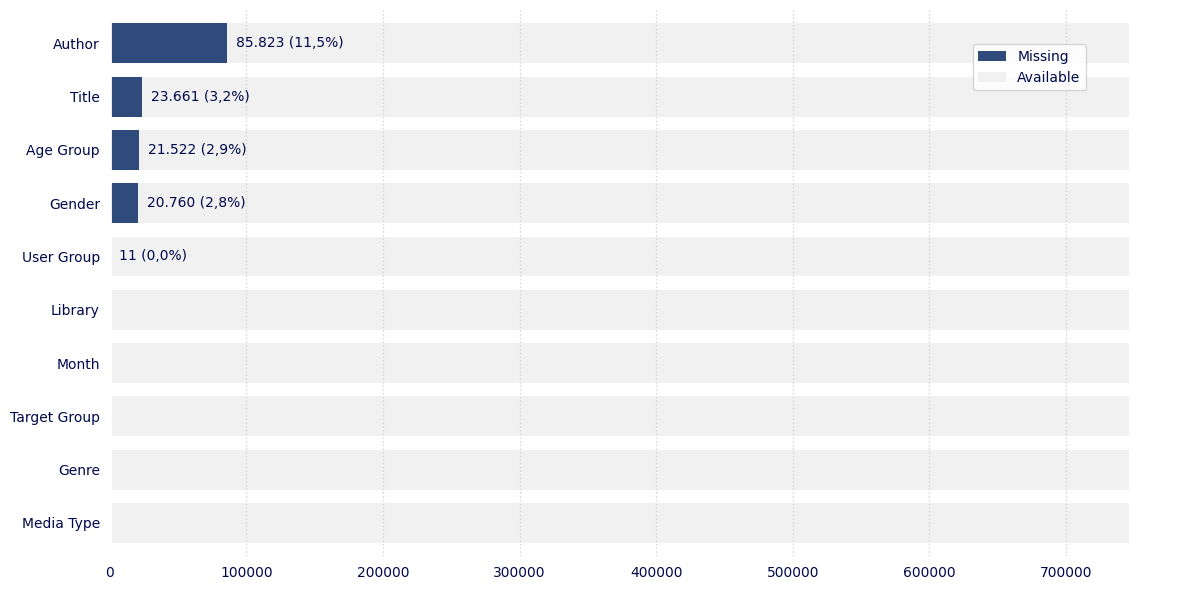

In [189]:
# Calculate per-variable missing & available counts
missing_counts = loans_df.isnull().sum()
available_counts = loans_df.shape[0] - missing_counts
total_rows = loans_df.shape[0]  

#Calculate total missing percentage 
total_cells = loans_df.shape[0] * loans_df.shape[1]
total_missing = missing_counts.sum()
total_missing_pct = (total_missing / total_cells)*100 

#Prepare data for stacked horizontal bar chart
stacked = pd.DataFrame({
    "Missing": missing_counts,
    "Available": available_counts
}).sort_values("Missing", ascending=True)

# Step 4: Plot
fig, ax = plt.subplots(figsize=(12, 6))
stacked.plot(
    kind="barh",
    stacked=True,
    color=["#2f4b7c", "#f1f1f1"],
    ax=ax,
    width=0.75
)

# Style settings
text_color = "#00094B"
ax.grid(axis='x', which='major', linestyle='dotted', color='lightgray', linewidth=1)
ax.axvline(x=0, color='white', linewidth=2)

# Remove spines and style ticks
for spine in ax.spines.values():
    spine.set_visible(False)

ax.tick_params(left=False, bottom=False)
ax.tick_params(axis='x', colors=text_color)
ax.tick_params(axis='y', colors=text_color)

# Add missing value labels with per-column percentages
for i, (col_name, row) in enumerate(stacked.iterrows()):
    missing_val = row["Missing"]
    if missing_val > 0:
        percent = (missing_val / total_rows) * 100
        ax.text(
            missing_val + total_rows * 0.009,
            i,
            f"{missing_val:,.0f}".replace(",", ".") + f" ({percent:.1f}%)".replace(".", ","),
            va='center',
            ha='left',
            color=text_color
        )

# Legend formatting
plt.legend(loc="upper left", bbox_to_anchor=(0.80, 0.95))
legend = ax.get_legend()
if legend:
    for text in legend.get_texts():
        text.set_color(text_color)

plt.tight_layout()
plt.show()

#### <u>Table 3</u> Missing Values by Attribute 

In [129]:
missing_counts

Title           23661
Author          85823
Media Type          0
Genre               0
User Group         11
Gender          20760
Age Group       21522
Target Group        0
Month               0
Library             0
dtype: int64

####  Number of Cells

In [191]:
total_cells

7460420

####  Number of Missing Cells

In [131]:
total_missing

151777

#### Share of Missing Cells 

In [132]:
total_missing_pct

2.0344296969875693

## 2.5. Generating Variable Statistics

### 2.5.1. Title

#### Number of Distinct Values

In [138]:
# Number of distinct titles 
unique_titles = loans_df["Title"].nunique()
unique_titles

126023

#### Share of Unique Values

In [147]:
# Distinct titles in % 
unique_titles_percent = (unique_titles / (total_rows-titles_missing)) * 100
unique_titles_percent

17.445503134772373

#### <u>Table 4</u> Borrowings by Title (Top 5)

In [160]:
loans_df["Title"].value_counts().head(5)

Title
Dinosaurier         544
Findus zieht um     254
Pferde und Ponys    249
Feuerwehr           222
Wale und Delfine    207
Name: count, dtype: int64

### 2.5.2. Author

#### Number of Distinct Values 

In [148]:
# Distinct authors total  
unique_authors = loans_df["Author"].nunique()
unique_authors

46142

#### Number of Missing Values

In [155]:
# Number of missing authors  
authors_missing = loans_df["Author"].isnull().sum()
authors_missing

85823

#### Share of Unique Values 

In [159]:
# Distinct authors in %
unique_authors_percent = (unique_authors / (total_rows-authors_missing)) * 100
unique_authors_percent

6.988893079417586

#### <u>Table 5</u> Borrowings by Author (Top 5)

In [161]:
#Top 5 authors 
loans_df["Author"].value_counts().head(5)

Author
Blanck, Ulf         6001
Minninger, André    5169
Siegner, Ingo       4899
Vogel, Maja von     3977
Auer, Margit        3456
Name: count, dtype: int64

### 2.5.3. Media type

<u>Key Takeaways</u>
* Books are by far the most borrowed media type, making up over 65% of all transactions.
* CDs and DVDs  play a significant role, together accounting for more than a quarter of borrowings.
* All other media types combined make up less than 10%, indicating their relatively minor importance in overall borrowing behavior.

#### <u>Table 6</u> Borrowings by Media Type: Frequency Table 

In [226]:
# Count borrowings per media type
freq_table = loans_df["Media Type"].value_counts().to_frame(name="Count")

# Reset index and rename for clarity
freq_table = freq_table.reset_index().rename(columns={"index": "Media Type"})

# Style the table: hide index, set text color and alignment, and style header
styled_table = freq_table.style \
    .hide(axis="index") \
    .set_properties(**{
        'color': '#00094B',
        'text-align': 'left'
    }) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [
                ('color', '#00094B'),
                ('text-align', 'left'),
                ('padding', '6px'),
                ('font-size', '12px')
            ]
        }
    ])

# Display the styled table
styled_table

Media Type,Count
Book,488740
CD,108294
DVD,85995
Magazine,38247
Conventional Game,11500
Console Game,5444
Media Combination,5096
Sheet Music,1387
Mobile Device,791
Software,441


#### <u>Figure 2</u> Borrowings by Media Type: Relative Frequencies

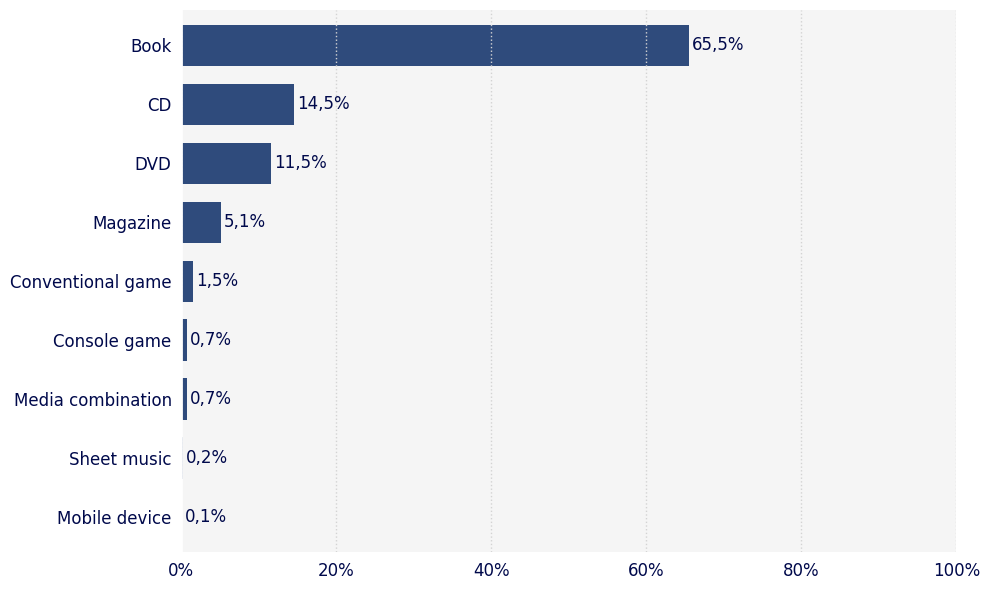

In [379]:

# Calculate value counts (absolute and relative)
value_counts = loans_df["Media Type"].value_counts(normalize=False)
value_counts_percent = loans_df["Media Type"].value_counts(normalize=True) * 100

# Apply 0.1% threshold
threshold = 0.1
non_zero = value_counts_percent[value_counts_percent > threshold].index

# Filtered relative frequencies
value_counts_percent_filtered = value_counts_percent[non_zero]

# Sort for horizontal bar chart
value_counts_sorted = value_counts_percent_filtered.sort_values(ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
value_counts_sorted.plot(
    kind="barh",
    color="#2f4b7c",
    ax=ax,
    width=0.7
)

# Styling
text_color = "#00094B"

# Add percentage labels
for i, (value, percent) in enumerate(value_counts_sorted.items()):
    ax.text(
        percent + 0.4,
        i,
        f"{percent:.1f}%".replace(".", ","),
        va='center',
        ha='left',
        color=text_color,
        fontsize=12  # <-- Label font size
    )

# Format x-axis to show 0–100% with percentage ticks
ax.set_xlim(0, 100)
ax.set_xticks(range(0, 101, 20))
ax.set_xticklabels(
    [f"{x}%" for x in range(0, 101, 20)],
    color=text_color,
    fontsize=12  # <-- X-axis tick font size
)

# Cleanup
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_facecolor("#f5f5f5")
ax.grid(axis='x', which='major', linestyle='dotted', color='lightgray', linewidth=1)
ax.axvline(x=0, color='white', linewidth=2)

# Y-axis ticks
ax.tick_params(left=False, bottom=False, labelsize=12)  # <-- Y-axis font size
ax.tick_params(axis='y', colors=text_color)
ax.set_ylabel("")  # Optional: leave empty or add fontsize if setting a label

plt.tight_layout()
plt.show()


### 2.5.4. Genre

<u>Key Takeaways</u>

* Fiction dominates borrowing behavior in the Pankow library dataset, accounting for nearly 68% of all borrowings.

* Non-fiction follows as the second most borrowed category, making up around 28%.

* Music and games combined represent less than 5%, indicating a marginal role in overall usage

#### <u>Table 7</u> Borrowings by Genre: Frequency Table 

In [227]:
# Count borrowings per genre
freq_table = loans_df["Genre"].value_counts().to_frame(name="Count")

# Reset index and rename for clarity
freq_table = freq_table.reset_index().rename(columns={"index": "Genre"})

# Style the table: hide index, set text color and alignment, and style header
styled_table = freq_table.style \
    .hide(axis="index") \
    .set_properties(**{
        'color': '#00094B',
        'text-align': 'left'
    }) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [
                ('color', '#00094B'),
                ('text-align', 'left'),
                ('padding', '6px'),
                ('font-size', '12px')
            ]
        }
    ])

# Display the styled table
styled_table

Genre,Count
Fiction,506243
Non-fiction,210384
Music,17708
Games,11707


#### <u>Figure 7</u> Borrowings by Genre: Relative Frequencies

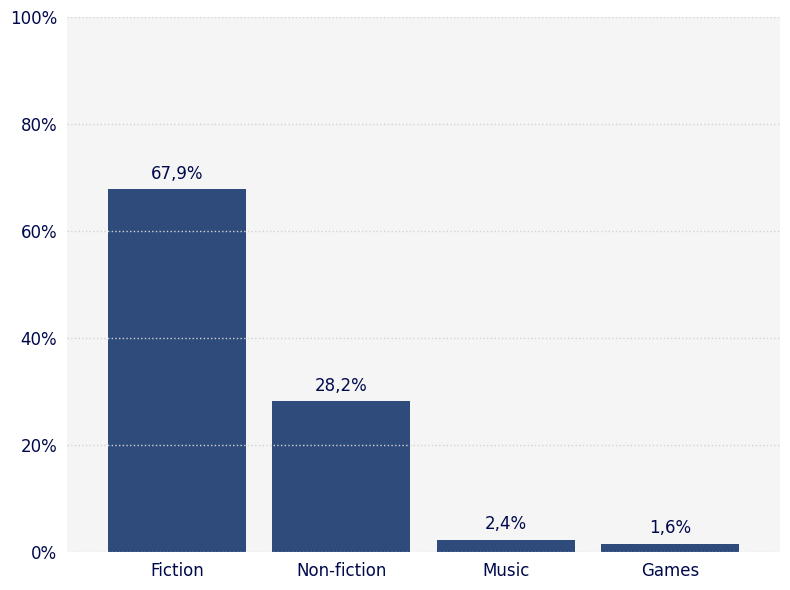

In [228]:
# Calculate value counts (absolute and relative)
value_counts = loans_df["Genre"].value_counts(normalize=False)
value_counts_percent = loans_df["Genre"].value_counts(normalize=True) * 100

# Sort for vertical bar chart 
value_counts_sorted = value_counts_percent.sort_values(ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
value_counts_sorted.plot(
    kind="bar",
    color="#2f4b7c",
    ax=ax,
    width=0.84
)

# Styling
text_color = "#00094B"

# Add percentage labels above bars
for i, (label, percent) in enumerate(value_counts_sorted.items()):
    ax.text(
        i,
        percent + 1.2,  # small gap above the bar
        f"{percent:.1f}%".replace(".", ","),
        ha='center',
        va='bottom',
        color=text_color,
        fontsize=12
    )

# Format y-axis as percentage
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels(
    [f"{x}%" for x in range(0, 101, 20)],
    color=text_color,
    fontsize=12
)

# X-axis formatting
ax.set_xticklabels(value_counts_sorted.index, rotation=0, fontsize=12, color=text_color)

# Cleanup
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_facecolor("#f5f5f5")
ax.grid(axis='y', which='major', linestyle='dotted', color='lightgray', linewidth=1)

ax.tick_params(left=False, bottom=False)
ax.set_xlabel("")  # optional: remove or label
ax.set_ylabel("")

plt.tight_layout()
plt.show()


### 2.5.5. User Groups

<u>Key Takeaways</u>
* Adults are the most acitve group, accounting for 43.3% of all transactions. 

* Children and Youth follow closely behind, making up 39.5% of borrowings.

* All other user groups combined account for less than 20%


#### <u>Table 8</u> Borrowings by User Groups: Frequency Table 

In [230]:
freq_table = loans_df["User Group"].value_counts().to_frame(name="Count")
freq_table = freq_table.reset_index().rename(columns={"index": "Media Type"})

# Style the table
styled_table = freq_table.style \
    .hide(axis="index") \
    .set_properties(**{
        'color': '#00094B',
        'text-align': 'left'
    }) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [
                ('color', '#00094B'),
                ('text-align', 'left'),
                ('padding', '6px'),
                ('font-size', '12px')
            ]
         }
    ])

# Display
styled_table

User Group,Count
Adults,322935
Children and Youth,294581
Adults (no charge),46586
Library Staff,24541
Adults (reduced rate),23464
Public Institution,22835
Students 16+,9576
Refugees,1501
Berlin Administration,12


#### <u>Figure 3</u> Borrowings by User Groups: Relative Frequencies

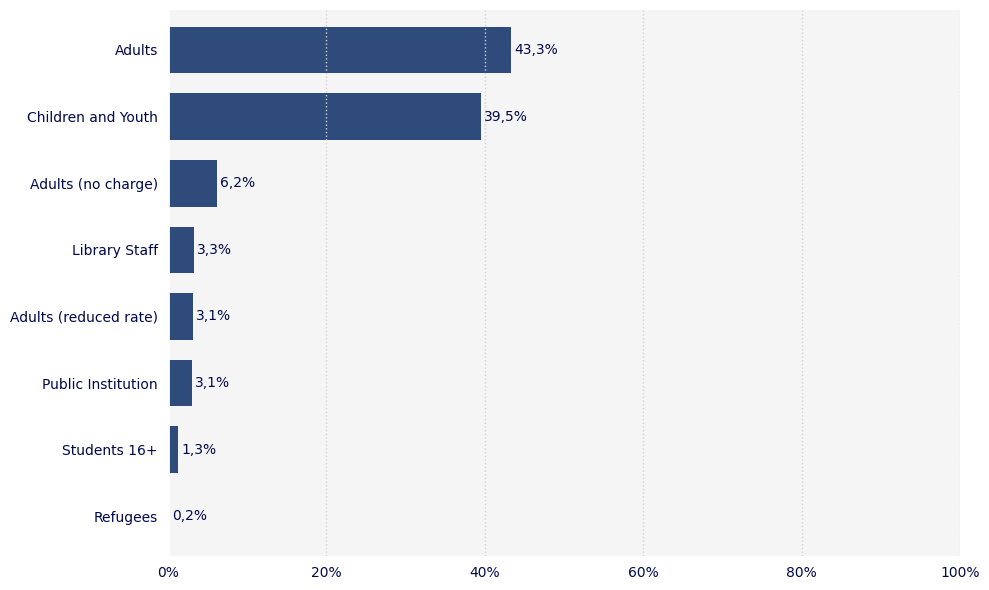

In [422]:
# Calculate value counts (absolute and relative)
value_counts = loans_df["User Group"].value_counts(normalize=False)
value_counts_percent = loans_df["User Group"].value_counts(normalize=True) * 100

# Apply 0.1% threshold
threshold = 0.1
non_zero = value_counts_percent[value_counts_percent > threshold].index

value_counts_percent_filtered = value_counts_percent[non_zero]

# Sort for horizontal bar chart (percent values)
value_counts_sorted = value_counts_percent_filtered.sort_values(ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
value_counts_sorted.plot(
    kind="barh",
    color="#2f4b7c", 
    ax=ax, 
    width=0.7
)


# Add percentage labels next to bars
for i, (group, percent) in enumerate(value_counts_sorted.items()):
    ax.text(
        percent + 0.4,
        i,
        f"{percent:.1f}%".replace(".", ","),
        va='center',
        ha='left',
        color="#00094B",
        fontsize=10
    )

# X-axis as percentage ticks
ax.set_xlim(0, 100)
ax.set_xticks(range(0, 101, 20))
ax.set_xticklabels([f"{x}%" for x in range(0, 101, 20)], color=text_color)

# Cleanup
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_facecolor("#f5f5f5")
ax.grid(axis='x', which='major', linestyle='dotted', color='lightgray', linewidth=1)
ax.axvline(x=0, color='white', linewidth=2)

ax.tick_params(left=False, bottom=False)
ax.tick_params(axis='y', colors=text_color)
ax.set_ylabel("")

plt.tight_layout()
plt.show()

### 2.5.6. Gender

<u>Key Takeaways</u>

* Women account for the majority of library borrowings, accounting for more than 65% transactions.

* Men contribute significantly less, with only 38% of total borrowings.

* The category "No Information" is negligible, representing fewer than 0.1% of all records.

#### <u>Table 9</u> Borrowings by Gender: Frequency Table 

In [231]:
freq_table = loans_df["Gender"].value_counts().to_frame(name="Count")
freq_table = freq_table.reset_index().rename(columns={"index": "Gender"})

# Style the table
styled_table = freq_table.style \
    .hide(axis="index") \
    .set_properties(**{
        'color': '#00094B',
        'text-align': 'left'
    }) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [
                ('color', '#00094B'),
                ('text-align', 'left'),
                ('padding', '6px'),
                ('font-size', '12px')
            ]
        }
    ])

# Display
styled_table

Gender,Count
Female,449607
Male,274997
No Information,678


#### <u>Figure 4</u> Borrowings by Gender: Relative Frequencies 

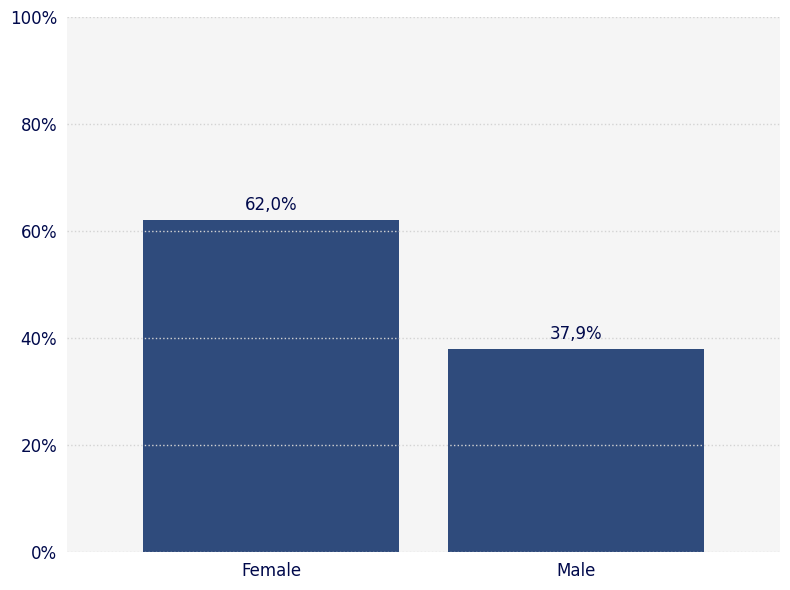

In [439]:
# Calculate value counts (absolute and relative)
value_counts = loans_df["Gender"].value_counts(normalize=False)
value_counts_percent = loans_df["Gender"].value_counts(normalize=True) * 100

# Apply 0.1% threshold
threshold = 0.1
non_zero = value_counts_percent[value_counts_percent > threshold].index

# Filtered relative frequencies
value_counts_percent_filtered = value_counts_percent[non_zero]

# Sort for vertical bar chart 
value_counts_sorted = value_counts_percent_filtered.sort_values(ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
value_counts_sorted.plot(
    kind="bar",               
    color="#2f4b7c",
    ax=ax,
    width=0.84
)

# Styling
text_color = "#00094B"

# Add percentage labels **above** bars
for i, (label, percent) in enumerate(value_counts_sorted.items()):
    ax.text(
        i,
        percent + 1.2,  # small gap above the bar
        f"{percent:.1f}%".replace(".", ","),
        ha='center',
        va='bottom',
        color=text_color,
        fontsize=12
    )

# Format y-axis as percentage
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels(
    [f"{x}%" for x in range(0, 101, 20)],
    color=text_color,
    fontsize=12
)

# X-axis formatting
ax.set_xticklabels(value_counts_sorted.index, rotation=0, fontsize=12, color=text_color)

# Cleanup
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_facecolor("#f5f5f5")
ax.grid(axis='y', which='major', linestyle='dotted', color='lightgray', linewidth=1)

ax.tick_params(left=False, bottom=False)
ax.set_xlabel("")  
ax.set_ylabel("")

plt.tight_layout()
plt.show()


### 2.5.7 Age Groups

<u>Key Takeaways</u>
* Borrowing activity is highest among users aged 40–54 (23.7%) and 6–10 years (21.7%), followed by the 25–39 age group (14.5%).
* Borrowing activity drops noticeably during adolescence, particularly between ages 11 and 17, suggesting a phase of disengagement from library use during this stage of life.

#### <u>Table 10</u> Borrowings by Age Groups: Frequency Table (sorted)

In [441]:

freq_table = loans_df["Age Group"].value_counts().to_frame(name="Count")
freq_table = freq_table.reset_index().rename(columns={"index": "Age Group"})

# Style the table
styled_table = freq_table.style \
    .hide(axis="index") \
    .set_properties(**{
        'color': '#00094B',
        'text-align': 'left'
    }) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [
                ('color', '#00094B'),
                ('text-align', 'left'),
                ('padding', '6px'),
                ('font-size', '12px')
            ]
        }
    ])

# Display
styled_table

Age Group,Count
40-54,172026
6-10,157276
25-39,105398
0-5,73937
55-64,69711
11-14,57500
65-79,53886
15-17,12223
80+,11595
18-24,10968


#### <u>Figure 5</u> Age Groups: Relative Frequencies 

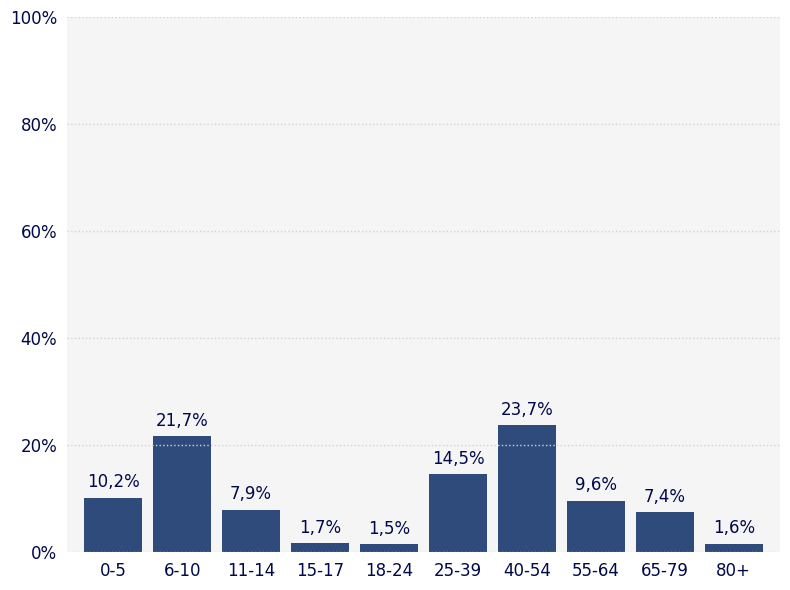

In [448]:
# Calculate value counts (absolute and relative)
value_counts = loans_df["Age Group"].value_counts(normalize=False)
value_counts_percent = loans_df["Age Group"].value_counts(normalize=True) * 100

# Reorder according to age_order
value_counts_percent = value_counts_percent.reindex(age_order)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
value_counts_percent.plot(
    kind="bar",
    color="#2f4b7c",
    ax=ax,
    width=0.84
)

# Styling
text_color = "#00094B"

# Add percentage labels above bars
for i, (label, percent) in enumerate(value_counts_percent.items()):
    if pd.notna(percent):
        ax.text(
            i,
            percent + 1.2,
            f"{percent:.1f}%".replace(".", ","),
            ha='center',
            va='bottom',
            color=text_color,
            fontsize=12
        )

# Format y-axis as percentage
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels([f"{x}%" for x in range(0, 101, 20)], color=text_color, fontsize=12)

# X-axis formatting
ax.set_xticklabels(value_counts_percent.index, rotation=0, fontsize=12, color=text_color)

# Cleanup
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_facecolor("#f5f5f5")
ax.grid(axis='y', which='major', linestyle='dotted', color='lightgray', linewidth=1)

ax.tick_params(left=False, bottom=False)
ax.set_xlabel("")
ax.set_ylabel("")

plt.tight_layout()
plt.show()


### 2.5.8. Target Groups

<u>Key Takeaways</u>
* Children are the primary target group, accounting for 64.4% of all borrowings — over 480,000 items.

* Adults represent a significant secondary group, with 35.6% of borrowings (~266,000 items).

* Youth-targeted items are nearly absent, with only 43 borrowings total, a serious classification gap or lack of materials effectively labeled for this group.

#### <u>Table 11</u> Borrowings by Target Groups: Frequency Table 

In [450]:
freq_table = loans_df["Target Group"].value_counts().to_frame(name="Count")
freq_table = freq_table.reset_index().rename(columns={"index": "Target Group"})

# Style the table
styled_table = freq_table.style \
    .hide(axis="index") \
    .set_properties(**{
        'color': '#00094B',
        'text-align': 'left'
    }) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [
                ('color', '#00094B'),
                ('text-align', 'left'),
                ('padding', '6px'),
                ('font-size', '12px')
            ]
        }
    ])

# Display
styled_table

Target Group,Count
Children,480183
Adults,265816
Youth,43


#### <u>Figure 6</u> Target Groups: Relative Frequencies

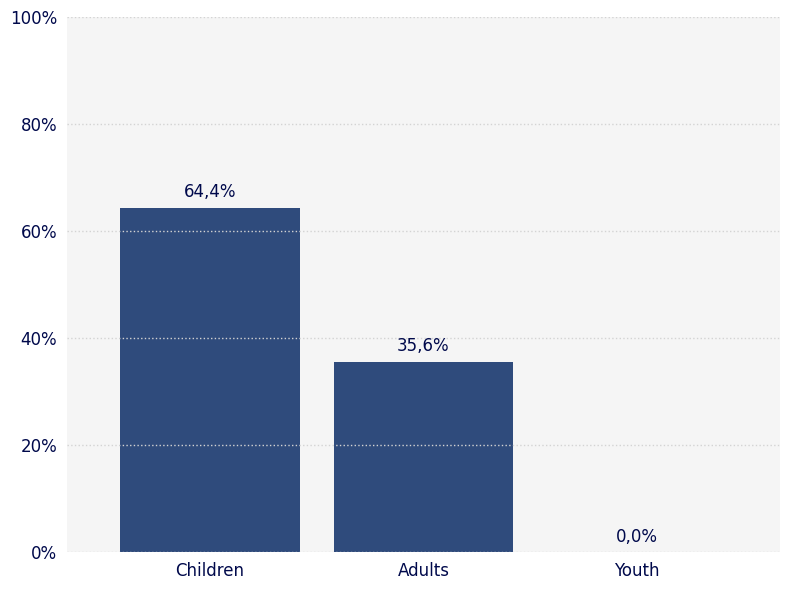

In [452]:
# Calculate value counts (absolute and relative)
value_counts = loans_df["Target Group"].value_counts(normalize=False)
value_counts_percent = loans_df["Target Group"].value_counts(normalize=True) * 100

# Sort values
value_counts_sorted = value_counts_percent.sort_values(ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
value_counts_sorted.plot(
    kind="bar",               
    color="#2f4b7c",
    ax=ax,
    width=0.84
)

# Styling
text_color = "#00094B"

# Add percentage labels above bars
for i, (label, percent) in enumerate(value_counts_sorted.items()):
    ax.text(
        i,
        percent + 1.2,  # small gap above the bar
        f"{percent:.1f}%".replace(".", ","),
        ha='center',
        va='bottom',
        color=text_color,
        fontsize=12
    )

# Format y-axis as percentage
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels(
    [f"{x}%" for x in range(0, 101, 20)],
    color=text_color,
    fontsize=12
)

# X-axis formatting
ax.set_xticklabels(value_counts_sorted.index, rotation=0, fontsize=12, color=text_color)

# Cleanup
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_facecolor("#f5f5f5")
ax.grid(axis='y', which='major', linestyle='dotted', color='lightgray', linewidth=1)

ax.tick_params(left=False, bottom=False)
ax.set_xlabel("") 
ax.set_ylabel("")

plt.tight_layout()
plt.show()

### 2.5.9 Month 

<u>Key Takeaways</u>

* Borrowing activity peaks in November and December, suggesting increased library use toward the end of the year. 

* In contrast, July shows the lowest share (5.5%), likely reflecting reduced borrowing during the summer break. 

#### <u>Table 12</u> Borrowings by Month: Frequency Table (sorted) 

In [465]:
freq_table = loans_df["Month"].value_counts().to_frame(name="Count")
freq_table = freq_table.reset_index().rename(columns={"index": "Month"})

# Style the table
styled_table = freq_table.style \
    .hide(axis="index") \
    .set_properties(**{
        'color': '#00094B',
        'text-align': 'left'
    }) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [
                ('color', '#00094B'),
                ('text-align', 'left'),
                ('padding', '6px'),
                ('font-size', '12px')
            ]
        }
    ])

# Display
styled_table

Month,Count
November,75302
October,72496
September,71022
May,69956
December,69788
August,67597
January,63064
March,57082
February,53481
April,53124


#### <u>Figure 7</u> Borrowings by Month: Relative Frequencies 

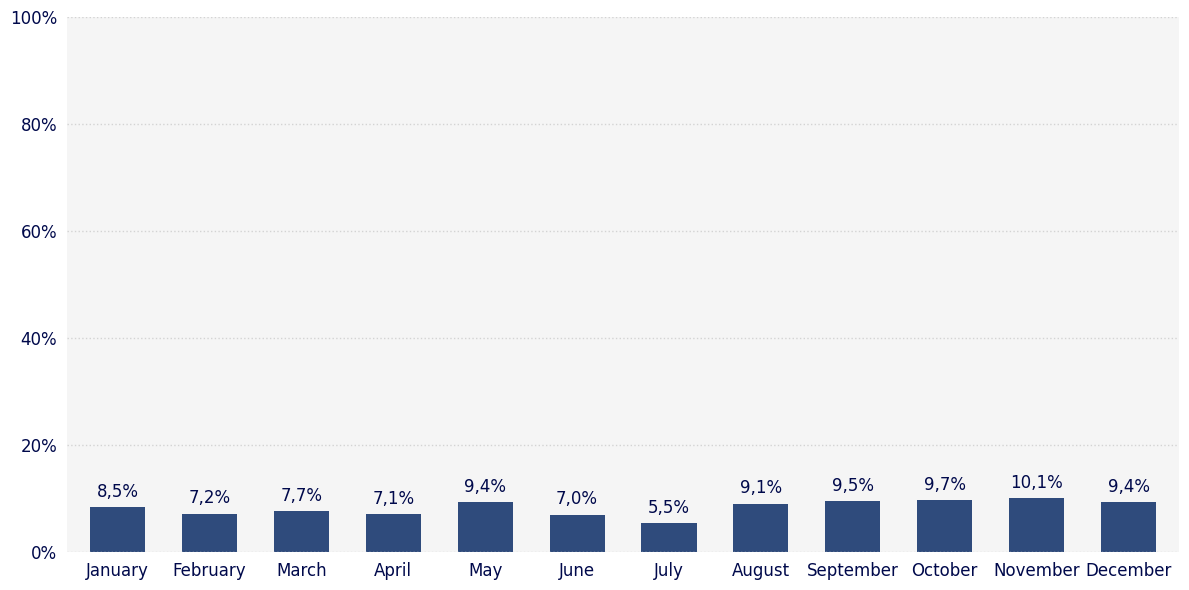

In [464]:
# Calculate value counts (absolute and relative)
value_counts = loans_df["Month"].value_counts(normalize=False)
value_counts_percent = loans_df["Month"].value_counts(normalize=True) * 100

# Order according to month_order 
value_counts_percent = value_counts_percent.reindex(month_order)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
value_counts_percent.plot(
    kind="bar",
    color="#2f4b7c",
    ax=ax,
    width=0.6
    
)

# Styling
text_color = "#00094B"

# Add percentage labels above bars
for i, (label, percent) in enumerate(value_counts_percent.items()):
    if pd.notna(percent):
        ax.text(
            i,
            percent + 1.2,
            f"{percent:.1f}%".replace(".", ","),
            ha='center',
            va='bottom',
            color=text_color,
            fontsize=12
        )

# Format y-axis as percentage
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels([f"{x}%" for x in range(0, 101, 20)], color=text_color, fontsize=12)

# X-axis formatting
ax.set_xticklabels(value_counts_percent.index, rotation=0, fontsize=12, color=text_color)

# Cleanup
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_facecolor("#f5f5f5")
ax.grid(axis='y', which='major', linestyle='dotted', color='lightgray', linewidth=1)

ax.tick_params(left=False, bottom=False)
ax.set_xlabel("")
ax.set_ylabel("")

plt.tight_layout()
plt.show()

### 2.5.10. Library

<u>Key Takeaways</u>
* Janusz-Korczak-Bibliothek accounts for the largest share of borrowings, with 26.4% of all recorded transactions in the district.

* A core group of five libraries (Janusz-Korczak, Wolfdietrich-Schnurre, Bettina-von-Arnim, Am Wasserturm, and Heinrich-Böll) together make up over 80% of total borrowings.

* The two Buch-Karow branches (Karow and Buch) show the lowest borrowing shares, possibly reflecting lower usage or more limited collections.

#### <u>Table 13</u> Borrowings by Library: Frequency Table 

In [468]:
freq_table = loans_df["Library"].value_counts().to_frame(name="Count")
freq_table = freq_table.reset_index().rename(columns={"index": "Library"})

# Style the table
styled_table = freq_table.style \
    .hide(axis="index") \
    .set_properties(**{
        'color': '#00094B',
        'text-align': 'left'
    }) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [
                ('color', '#00094B'),
                ('text-align', 'left'),
                ('padding', '6px'),
                ('font-size', '12px')
            ]
        }
    ])

# Display
styled_table

Library,Count
Janusz-Korczak-Bibliothek,197247
Wolfdietrich-Schnurre-Bibliothek,113907
Bettina-von-Arnim-Bibliothek,111079
Bibliothek Am Wasserturm,100718
Heinrich-Böll-Bibliothek,95245
Kurt-Tucholsky-Bibliothek,48847
Stadtteilbibliothek Buch-Karow (Karow),45314
Stadtteilbibliothek Buch-Karow (Buch),33685


#### <u>Figure 8</u> Borrowings by Library: Relative Frequencies 

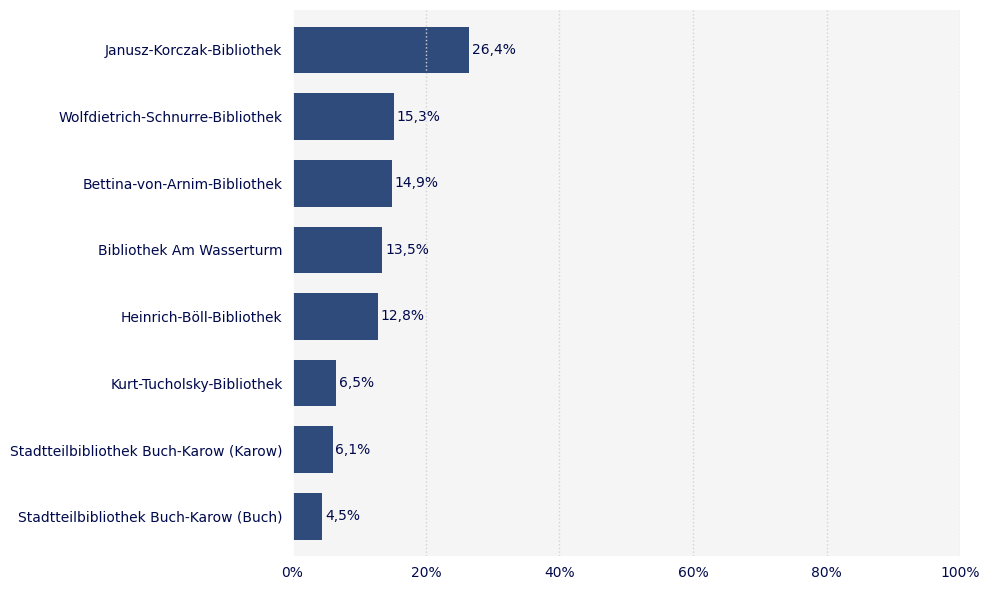

In [232]:
# Calculate value counts (absolute and relative)
value_counts = loans_df["Library"].value_counts(normalize=False)
value_counts_percent = loans_df["Library"].value_counts(normalize=True) * 100

# value counts sorted
value_counts_sorted = value_counts_percent.sort_values(ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
value_counts_sorted.plot(
    kind="barh",
    color="#2f4b7c",
    ax=ax,
    width=0.7
)

# Add percentage labels next to bars
for i, (group, percent) in enumerate(value_counts_sorted.items()):
    ax.text(
        percent + 0.4,
        i,
        f"{percent:.1f}%".replace(".", ","),
        va='center',
        ha='left',
        color="#00094B",
        fontsize=10
    )

# X-axis as percentage ticks
ax.set_xlim(0, 100)
ax.set_xticks(range(0, 101, 20))
ax.set_xticklabels([f"{x}%" for x in range(0, 101, 20)], color="#00094B")

# Cleanup
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_facecolor("#f5f5f5")
ax.grid(axis='x', which='major', linestyle='dotted', color='lightgray', linewidth=1)
ax.axvline(x=0, color='white', linewidth=2)

ax.tick_params(left=False, bottom=False)
ax.tick_params(axis='y', colors="#00094B")
ax.set_ylabel("")

plt.tight_layout()
plt.show()


## 2.6. Exploring Correlations 

<u>Key Takeaways</u>

* Media Type and Genre show the strongest association among all variable pairs (Cramér’s V = 0.64), reflecting a — unsurprising — strong alignment between the type of media and its thematic classification.

* Age Group is – as to be expected –  associated with both Target Group and User Group (V = 0.46 each)

* Gender, Month, and Library show weak associations with most other variables (V < 0.2), suggesting these attributes play a less structurally defining role in borrowing patterns.

#### <u>Table 14</u> Cramér’s V matrix 

In [35]:
# list of categorical variables
categorical_vars = [
    "Media Type", "Genre", "Gender", "Age Group", 
    "Target Group", "User Group", "Month", "Library"
]

# Initialize an empty matrix (DataFrame)
cramers_v_matrix = pd.DataFrame(
    data=np.zeros((len(categorical_vars), len(categorical_vars))),
    index=categorical_vars,
    columns=categorical_vars
)

# Fill the matrix with Cramér's V values
for var1 in categorical_vars:
    for var2 in categorical_vars:
        # Create contingency table
        table = pd.crosstab(loans_df[var1], loans_df[var2])
        # Compute Cramér’s V with optional correction
        v = association(table, method='cramer', correction=True)
        # Assign to matrix
        cramers_v_matrix.loc[var1, var2] = v

cramers_v_matrix

,Media Type,Genre,Gender,Age Group,Target Group,User Group,Month,Library
Media Type,1.000000,0.635796,0.067788,0.084493,0.181331,0.089309,0.016059,0.073841
Genre,0.635796,1.000000,0.046371,0.107908,0.182241,0.092422,0.023273,0.062019
Gender,0.067788,0.046371,1.000000,0.162584,0.031796,0.201492,0.039405,0.055969
Age Group,0.084493,0.107908,0.162584,1.000000,0.455476,0.464972,0.025625,0.094149
Target Group,0.181331,0.182241,0.031796,0.455476,1.000000,0.375308,0.029033,0.131843
User Group,0.089309,0.092422,0.201492,0.464972,0.375308,1.000000,0.023875,0.091805
Month,0.016059,0.023273,0.039405,0.025625,0.029033,0.023875,1.000000,0.082524
Library,0.073841,0.062019,0.055969,0.094149,0.131843,0.091805,0.082524,1.000000


#### <u>Figure 9</u> Cramér’s V Heatmap 

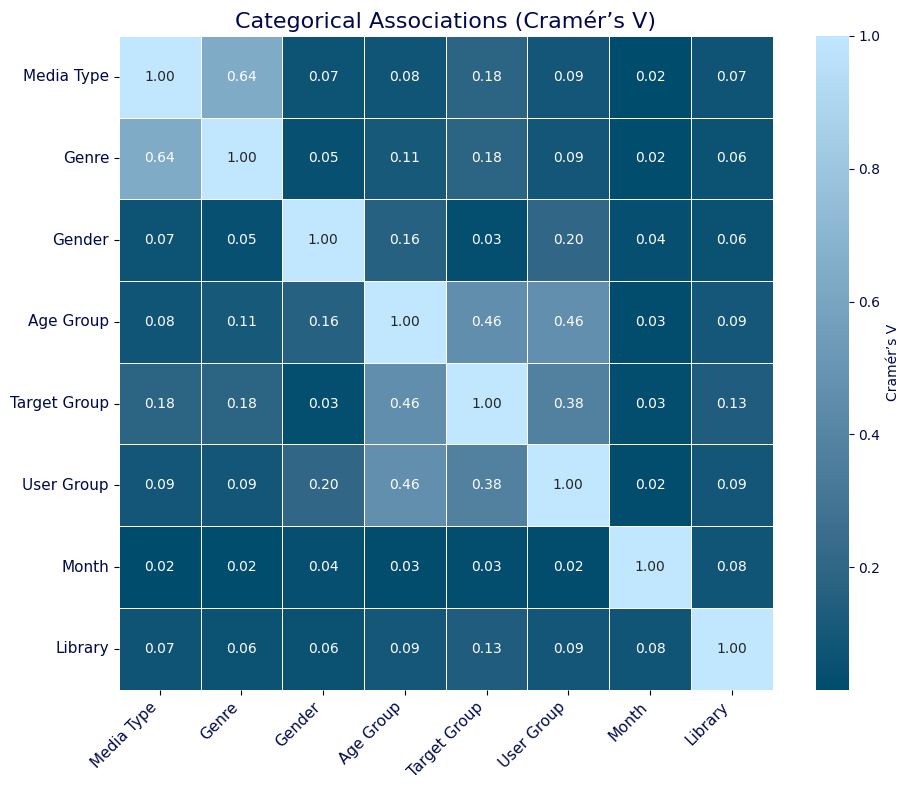

In [36]:
# Define a custom sequential blue color palette for the heatmap
custom_colors = ["#004c6d", "#346888", "#5886a5", "#7aa6c2", "#9dc6e0", "#c1e7ff"]
custom_cmap = LinearSegmentedColormap.from_list("custom_blue", custom_colors)

# Ensure the Cramér’s V matrix contains float values 
cramers_v_matrix = cramers_v_matrix.astype(float)

# Create the heatmap plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    cramers_v_matrix,
    annot=True,                   # Display the Cramér’s V values inside the cells
    fmt=".2f",                    # Format float annotations to 2 decimal places
    cmap=custom_cmap,             # Apply the custom color palette
    linewidths=0.5,               # Light grid lines between cells
    square=True,                  # Keep cells square-shaped
    cbar_kws={"label": "Cramér’s V"}  # Label for the color bar
)

# Set universal text color for titles, axis ticks, and labels
text_color = "#00094B"

# Add a title and style the axis tick labels
plt.title("Categorical Associations (Cramér’s V)", fontsize=16, color=text_color)
plt.xticks(rotation=45, ha="right", fontsize=11, color=text_color)
plt.yticks(rotation=0, fontsize=11, color=text_color)

# Style the color bar with consistent text color
cbar = plt.gca().collections[0].colorbar
cbar.ax.yaxis.label.set_color(text_color)
cbar.ax.tick_params(colors=text_color)

# Optimize spacing and render the plot
plt.tight_layout()
plt.show()

# 3. Exploring Youth Disengagement in Pankow’s Libraries 

## 3.1. Key Finding 1: Library Engagement is Structured Around Parenthood

* Library engagement appears to follow the rhythms of parenting. Borrowing activity is high during early childhood (ages 0–5 and 6–10), with a clear peak in the 6–10 age group – also reflecting parental involvement in early childhood library engagement (see Figure 5) 

* Engagement drops sharply during adolescence and young adulthood (ages 15–24), marking a disengagement phase. However, borrowing levels rise again in the 25–39 age group, aligning with the transition into parenthood (see Figure 5) 

* The parenting-driven nature of borrowing behavior also becomes evident when analyzing the target groups of items borrowed from Pankow’s libraries: Children aged 0–10 almost exclusively borrow items labeled with target group "Children" – indicating a strong alignment between the target group and the actual user group. As expected, the share of items borrowed targeting children decreases with age, particularly during adolescence. Interestingly, however, this trend reverses in the 25–39 age group, where the proportion of “children’s books” borrowed rises again — most likely reflecting the borrowing behavior of parents on behalf of their children (see Table 14 & Figure 6)   


#### <u>Figure 5</u> Borrowings by Age Groups: Relative Frequencies 

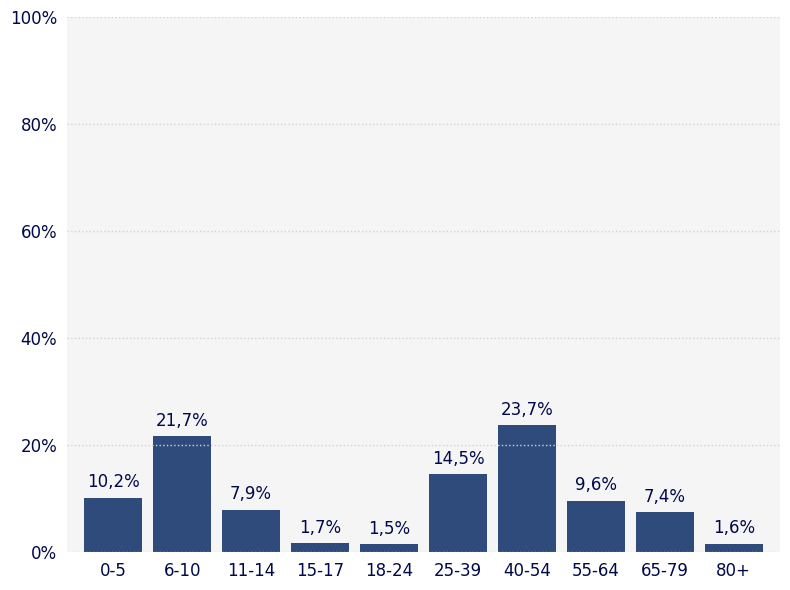

In [233]:
# Calculate absolute and relative frequencies for Age Group 
value_counts = loans_df["Age Group"].value_counts(normalize=False) 
value_counts_percent = loans_df["Age Group"].value_counts(normalize=True) * 100  

# Ensure correct age group order 
value_counts_percent = value_counts_percent.reindex(age_order)

# Create bar chart of relative frequencies
fig, ax = plt.subplots(figsize=(8, 6))
value_counts_percent.plot(
    kind="bar",
    color="#2f4b7c",
    ax=ax,
    width=0.84
)

# Add percentage labels above each bar
text_color = "#00094B"
for i, (label, percent) in enumerate(value_counts_percent.items()):
    if pd.notna(percent):
        ax.text(
            i,
            percent + 1.2,  # Slight offset above bar
            f"{percent:.1f}%".replace(".", ","),  # Format as "12,3%"
            ha='center',
            va='bottom',
            color=text_color,
            fontsize=12
        )

# Format Y-axis as percentage 
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels(
    [f"{x}%" for x in range(0, 101, 20)],
    color=text_color,
    fontsize=12
)

# Format X-axis labels
ax.set_xticklabels(
    value_counts_percent.index,
    rotation=0,
    fontsize=12,
    color=text_color
)

# Style plot background and grid 
ax.set_facecolor("#f5f5f5")
ax.grid(
    axis='y',
    which='major',
    linestyle='dotted',
    color='lightgray',
    linewidth=1
)

# Cleanup
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False)
ax.set_xlabel("")
ax.set_ylabel("")

# Final layout and display 
plt.tight_layout()
plt.show()

#### <u>Table 15</u> Borrowings by Age and Target Groups: Frequency Table

In [197]:
# Create the crosstab table
crosstab_table = pd.crosstab(loans_df['Age Group'], loans_df['Target Group'])

# Reset index to turn it into a regular DataFrame
crosstab_df = crosstab_table.reset_index()

# Style the table
styled_crosstab = crosstab_df.style \
    .hide(axis="index") \
    .set_properties(**{
        'color': '#00094B',
        'text-align': 'left'
    }) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [
                ('color', '#00094B'),
                ('text-align', 'left'),
                ('padding', '6px'),
                ('font-size', '12px')
            ]
        }
    ])

# Display
styled_crosstab

Age Group,Adults,Youth,Children
0-5,1590,2,72345
6-10,5857,8,151411
11-14,7284,0,50216
15-17,5937,0,6286
18-24,7168,2,3798
25-39,32822,6,72570
40-54,80484,9,91533
55-64,58792,6,10913
65-79,49723,8,4155
80+,11442,2,151


#### <u>Figure 10</u> Age Group Breakdown of Borrowed Items for the Target Group “Children”

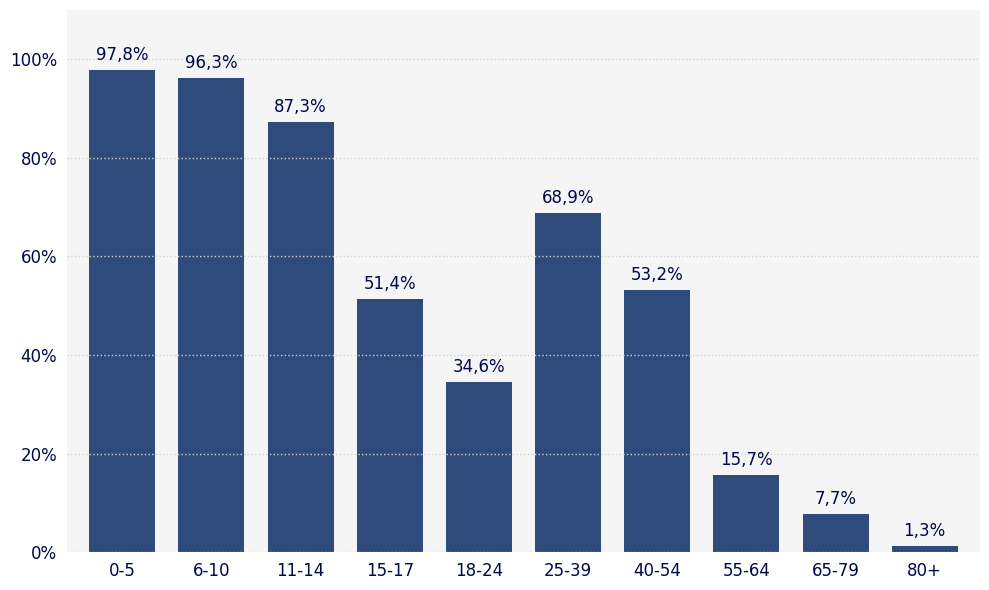

In [234]:
# Total borrowings per age group
total_per_age = loans_df['Age Group'].value_counts().reindex(age_order)

# Borrowings where Target Group == 'Children'
children_per_age = loans_df[loans_df['Target Group'] == 'Children']['Age Group'].value_counts().reindex(age_order)

# Calculate relative frequency in %
value_counts_percent = (children_per_age / total_per_age * 100)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
value_counts_percent.plot(
    kind="bar",
    color="#2f4b7c",
    ax=ax,
    width=0.74
)

# Styling
text_color = "#00094B"

# Add percentage labels above bars
for i, (label, percent) in enumerate(value_counts_percent.items()):
    if pd.notna(percent):
        ax.text(
            i,
            percent + 1.2,
            f"{percent:.1f}%".replace(".", ","),
            ha='center',
            va='bottom',
            color=text_color,
            fontsize=12
        )

# Format y-axis as percentage
ax.set_ylim(0, 110)
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels([f"{x}%" for x in range(0, 101, 20)], color=text_color, fontsize=12)

# X-axis formatting
ax.set_xticklabels(value_counts_percent.index, rotation=0, fontsize=12, color=text_color)

# Cleanup
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_facecolor("#f5f5f5")
ax.grid(axis='y', which='major', linestyle='dotted', color='lightgray', linewidth=1)
ax.tick_params(left=False, bottom=False)

# Remove axis labels
ax.set_xlabel("")
ax.set_ylabel("")

plt.tight_layout()
plt.show()

## 3.2. Key Finding 2: Youth Remains an Underdefined and Underused Target Group

* Out of a total of 746.042 borrowing transactions analyzed, only 43 items were labeled with the target group “Youth”.
* This suggests that the “Youth” category is either underutilized or – more likely – inconsistently applied within the library cataloging system. This indicates that little systematic attention is given to the interests and needs of young people and that they might be overlooked as a target group.
* Despite the overall low number of borrowed items labeled as targeting youth, it is noteworthy that only 2 out of these 43 borrowings were actually made by young people. This discrepancy indicates that not enough attention is paid to systematically target young people.  

#### <u>Figure 11</u> Number Borrowings by Target Groups

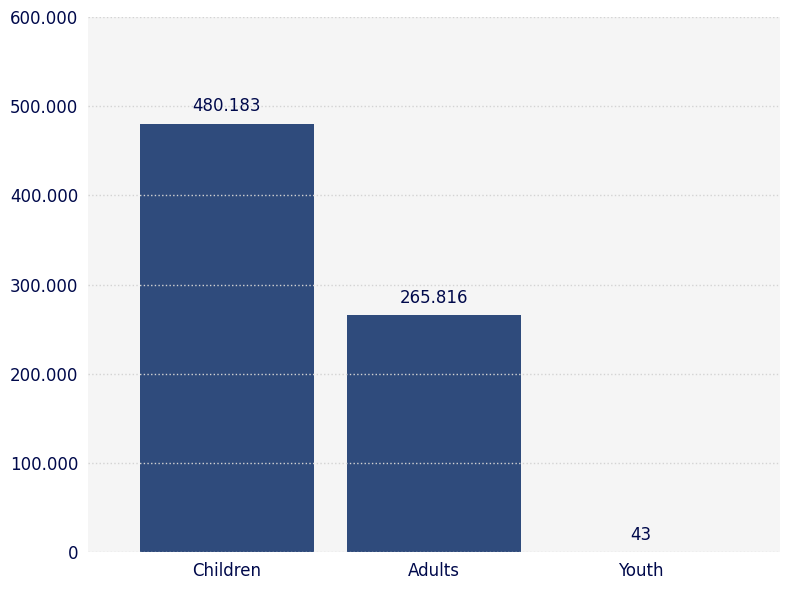

In [86]:
# Absolute counts per target group
value_counts = loans_df["Target Group"].value_counts(normalize=False)
value_counts_sorted = value_counts.sort_values(ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
value_counts_sorted.plot(
    kind="bar",               
    color="#2f4b7c",
    ax=ax,
    width=0.84
)

# Styling
text_color = "#00094B"

# Add count abels above bars
for i, (label, count) in enumerate(value_counts_sorted.items()):
    ax.text(
        i,
        count + (max(value_counts_sorted) * 0.02),
        f"{int(count):,}".replace(",", "."),
        ha='center',
        va='bottom',
        color=text_color,
        fontsize=12
    )

# Y-axis: absolute numbers
ax.set_ylim(0, max(value_counts_sorted) * 1.15)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(
    [f"{int(x):,}".replace(",", ".") for x in ax.get_yticks()],
    color=text_color,
    fontsize=12
)

# X-axis formatting
ax.set_xticklabels(value_counts_sorted.index, rotation=0, fontsize=12, color=text_color)

# Cleanup
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_facecolor("#f5f5f5")
ax.grid(axis='y', which='major', linestyle='dotted', color='lightgray', linewidth=1)

ax.tick_params(left=False, bottom=False)
ax.set_xlabel("")  
ax.set_ylabel("")

plt.tight_layout()
plt.show()

#### <u>Table 16</u> Age Group Breakdown of Borrowed Items for the Target Group “Children”

In [100]:
# Create crosstab
freq_table = pd.crosstab(loans_df['Age Group'], loans_df['Target Group'])

# Reset index so 'Age Group' becomes a column
freq_table = freq_table.reset_index()

# Define rows to highlight
highlight_rows = ["11-14","15-17", "18-24"]

# Define highlight function
def highlight_age_group(row):
    if row["Age Group"] in highlight_rows:
        return ['background-color: #9dc6e0'] * len(row)
    else:
        return [''] * len(row)

# Style the table
styled_table = freq_table.style \
    .hide(axis="index") \
    .apply(highlight_age_group, axis=1) \
    .set_properties(**{
        'color': '#00094B',
        'text-align': 'left'
    }) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [
                ('color', '#00094B'),
                ('text-align', 'left'),
                ('padding', '6px'),
                ('font-size', '12px')
            ]
        }
    ])

# Display
styled_table

Age Group,Adults,Youth,Children
0-5,1590,2,72345
6-10,5857,8,151411
11-14,7284,0,50216
15-17,5937,0,6286
18-24,7168,2,3798
25-39,32822,6,72570
40-54,80484,9,91533
55-64,58792,6,10913
65-79,49723,8,4155
80+,11442,2,151


## 3.3. Key Finding 3: Youth Disengagement is Predominantly Male 

* Early childhood borrowing (ages 0–10)** is relatively balanced between male and female users  
* From early adolescence onward, a gender gap emerges:  
      * Male borrowing declines noticeably in the 15–17 and 18–24 age groups  
      * At the same time, the share of female borrowings increases  
* In the 18–24 cohort, female users account for approximately 80% of all borrowings — an indicator of disengagement among young men  
* This gendered pattern persists across later age groups, with women consistently borrowing more than men  
* Overall, the data reveals a structural underrepresentation of young men in public library use, particularly during and after adolescence


#### <u>Figure 12</u> Borrowings by Age Group and Gender (binary) 

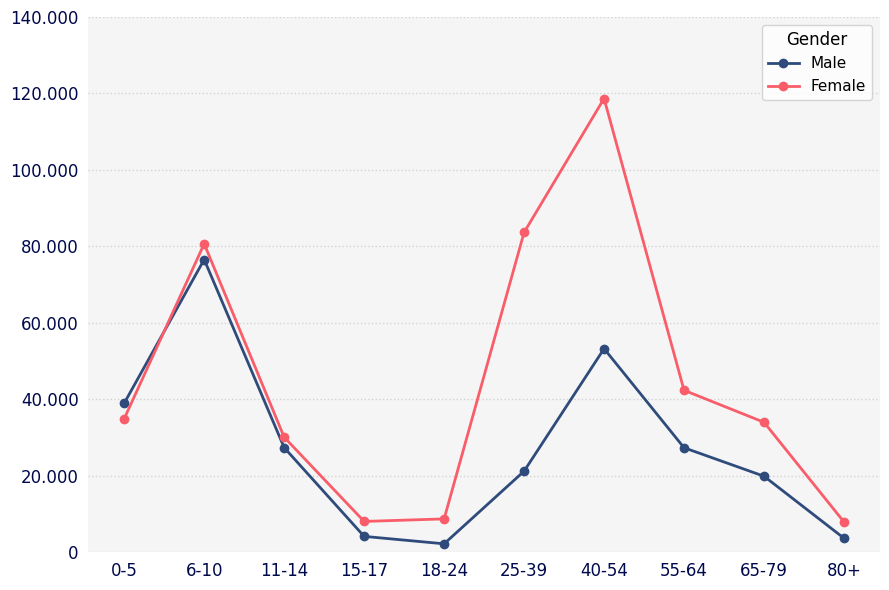

In [207]:
filtered_df = loans_df[loans_df["Gender"].isin(["Male", "Female"])]

#Create crosstab of borrow counts by age group and gender
gender_age_counts = pd.crosstab(filtered_df["Age Group"], filtered_df["Gender"])

# Plot
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(gender_age_counts.index, gender_age_counts["Male"], label="Male", marker='o', color="#2f4b7c", linewidth=2)
ax.plot(gender_age_counts.index, gender_age_counts["Female"], label="Female", marker='o', color="#f95d6a", linewidth=2)

# Styling
text_color = "#00094B"
ax.set_xlabel("")
ax.set_ylabel("")


# Y-axis formatting
ax.set_ylim(0, max(gender_age_counts.max()) * 1.02)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(
    [f"{int(y):,}".replace(",", ".") for y in ax.get_yticks()],
    fontsize=12,
    color=text_color
)

# X-axis formatting
ax.set_xticks(range(len(gender_age_counts.index)))
ax.set_xticklabels(gender_age_counts.index, rotation=0, fontsize=12, color=text_color)

# Grid and background
ax.set_facecolor("#f5f5f5")
ax.grid(axis='y', linestyle='dotted', color='lightgray', linewidth=1)

# Remove axis borders
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False)

# Legend
ax.legend(title="Gender", fontsize=11, title_fontsize=12)

plt.tight_layout()
plt.show()

#### <u>Table  17</u> Borrowings by Age Group and Gender (binary) 


In [210]:
# Create the crosstab table
freq_table = pd.crosstab(loans_df["Age Group"], loans_df["Library"])

# Reset index to turn it into a regular DataFrame
freq_df = freq_table.reset_index()

# Style the table
styled_freq_table = freq_df.style \
    .hide(axis="index") \
    .set_properties(**{
        'color': '#00094B',
        'text-align': 'left'
    }) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [
                ('color', '#00094B'),
                ('text-align', 'left'),
                ('padding', '6px'),
                ('font-size', '12px')
            ]
        }
    ])

# Display
styled_freq_table

Age Group,Heinrich-Böll-Bibliothek,Janusz-Korczak-Bibliothek,Stadtteilbibliothek Buch-Karow (Buch),Wolfdietrich-Schnurre-Bibliothek,Stadtteilbibliothek Buch-Karow (Karow),Bettina-von-Arnim-Bibliothek,Kurt-Tucholsky-Bibliothek,Bibliothek Am Wasserturm
0-5,4962,18739,2351,8746,5926,11310,9259,12644
6-10,12254,38243,5408,22374,14696,29265,12961,22075
11-14,6290,15255,1861,8486,4267,10670,3307,7364
15-17,2428,2876,403,2264,383,1877,532,1460
18-24,1370,2642,611,2934,394,1420,466,1131
25-39,13307,29135,6400,16367,5631,14619,5933,14006
40-54,26247,45171,7358,24840,5572,29049,10668,23121
55-64,13568,19530,2669,13291,1947,7412,2228,9066
65-79,8791,18180,4305,8205,4045,3359,1244,5757
80+,2838,4222,1336,1408,877,304,27,583


#### <u>Figure  13</u> Borrowings by Age Group and Gender: Relative Frequencies


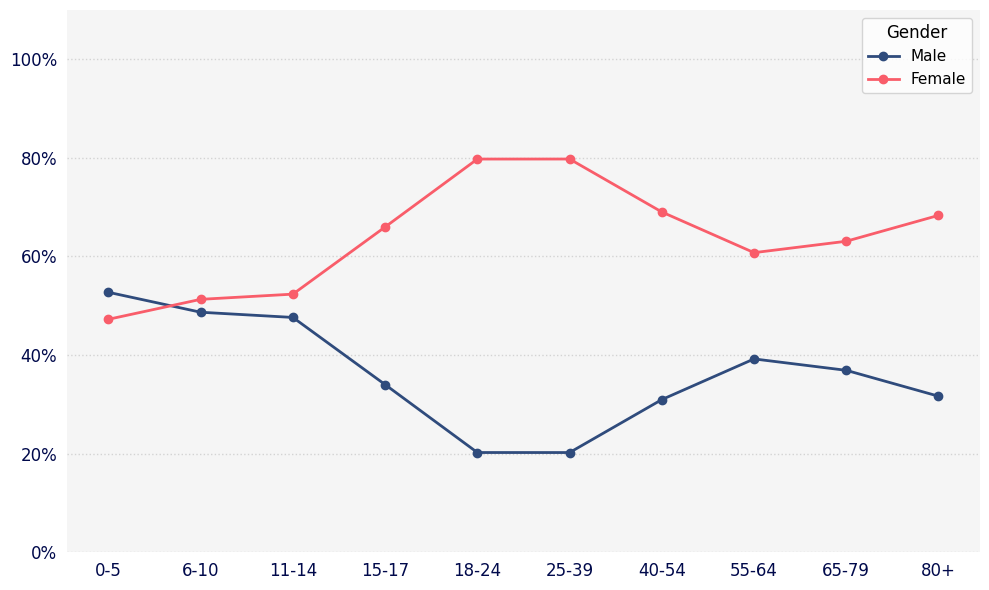

In [211]:
# Filter only Male/Female
gender_binary = ["Male", "Female"]
filtered_df = loans_df[loans_df["Gender"].isin(gender_binary)]

# Create row-normalized crosstab
rel_table = pd.crosstab(
    filtered_df["Age Group"],
    filtered_df["Gender"],
    normalize='index'
) * 100
rel_table = rel_table.reindex(age_order)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(rel_table.index, rel_table["Male"], label="Male", marker='o', color='#2f4b7c', linewidth=2)
ax.plot(rel_table.index, rel_table["Female"], label="Female", marker='o', color='#f95d6a', linewidth=2)

# Styling
text_color = "#00094B"
ax.set_xlabel("")
ax.set_ylabel("")

# Y-axis formatting
ax.set_ylim(0, 110)
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels([f"{x}%" for x in range(0, 101, 20)], fontsize=12, color=text_color)

# X-axis formatting
ax.set_xticks(range(len(age_order)))
ax.set_xticklabels(age_order, rotation=0, fontsize=12, color=text_color)

# Cleanup and styling
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_facecolor("#f5f5f5")
ax.grid(axis='y', linestyle='dotted', color='lightgray', linewidth=1)
ax.tick_params(left=False, bottom=False)
ax.legend(title="Gender", fontsize=11, title_fontsize=12)

plt.tight_layout()
plt.show()


## 3.4. Key Finding 4: What Young People Borrow (if they Borrow)

* Young people still read: In all youth age groups, books account for more than 65% of borrowings. In fact, the share of book borrowings is higher among youth than among the 40–54 (59.3%) and 55–64 (53.1%) age groups.
* CD borrowings remain relatively stable during childhood and adolescence, but drop significantly in the 18–24 age group. 
* While the 55–64 age group are the heaviest DVD users, the data also reveals that visual media plays a notable role among youth demographics.
* Console games are most popular among the 11–14 and 18–24 age groups
* While conventional games are most frequently borrowed in the context of early childhood (the high interest in age group 25-39 is likely explained by parents borrowing for their children), the elevated interest among 18–24-year-olds is noteworthy.
* Media Combinations are most popular among age group 15-17 and 18-24.
* Although mobile devices account for a small portion of total borrowings, their highest importance is observed among 18–24-year-olds — potentially indicating a functional demand linked to the start of higher education or vocational pathways.
* Youth borrow5 fewer magazines compared to other age groups — possibly due to shifting media habits or a disconnect between available titles and their interests.

#### <u> Figures 14-22</u> Borrowings by Age Group and Media Types: Relative Frequencies 

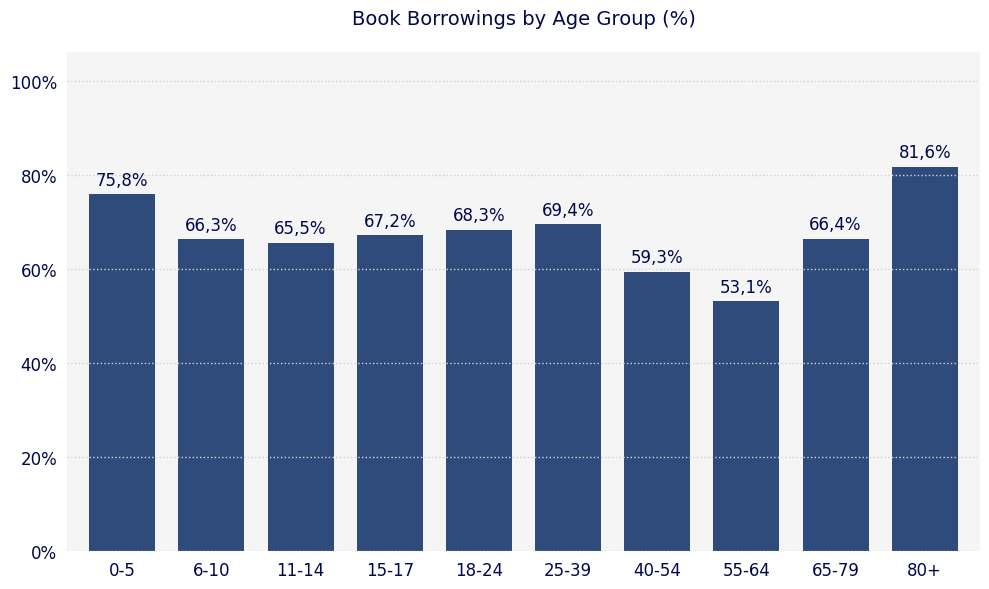

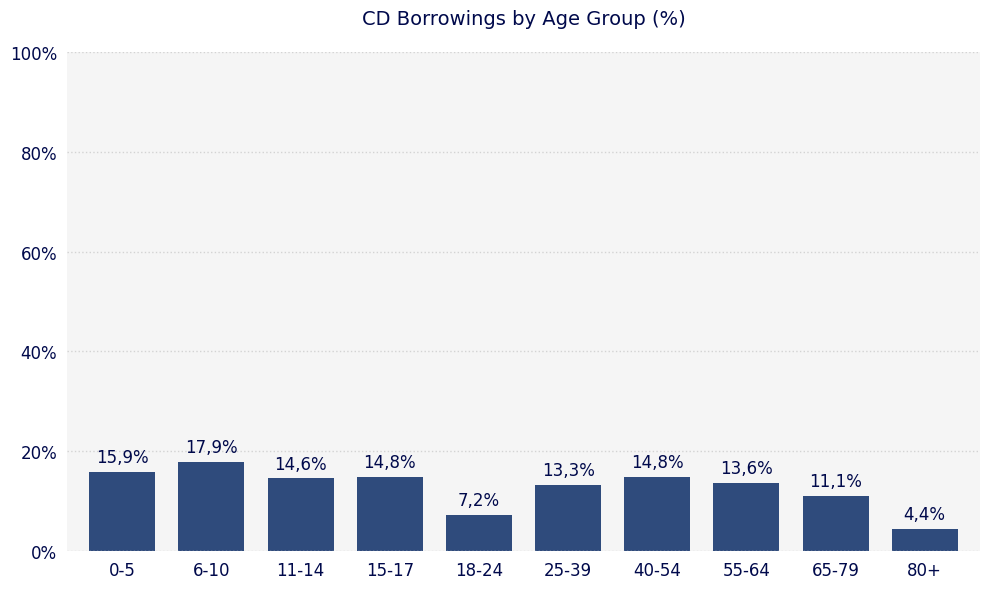

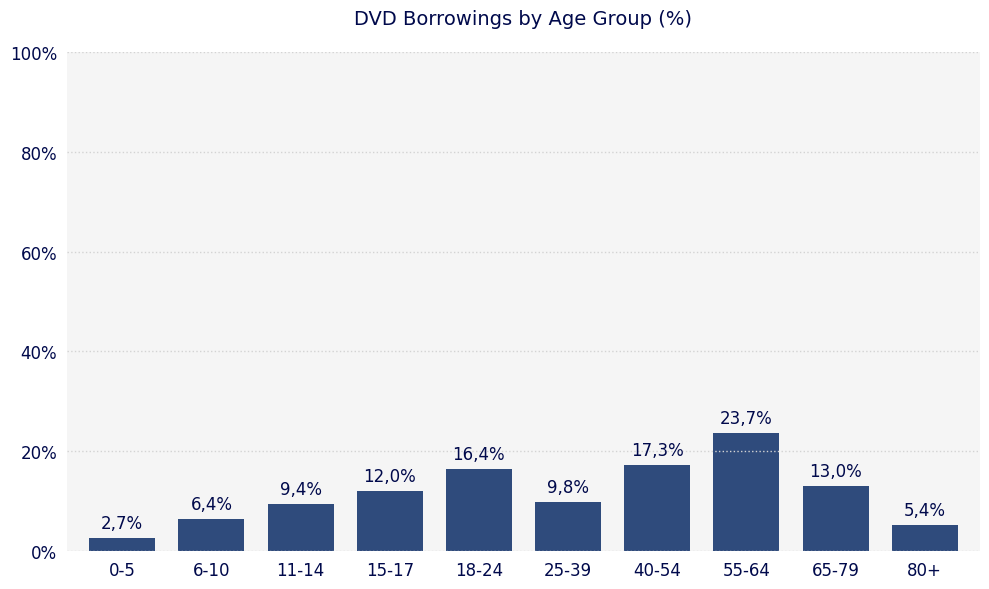

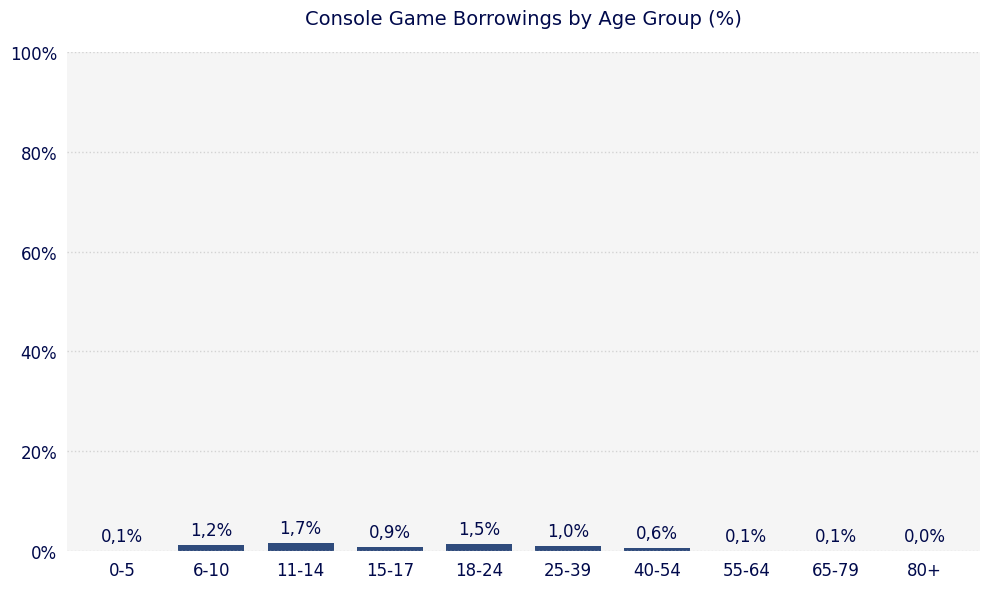

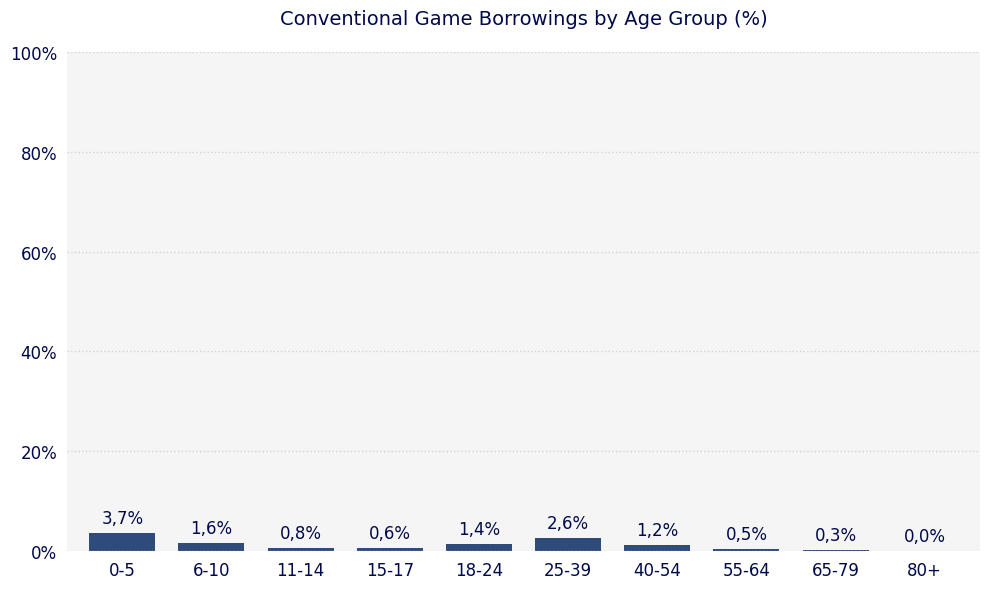

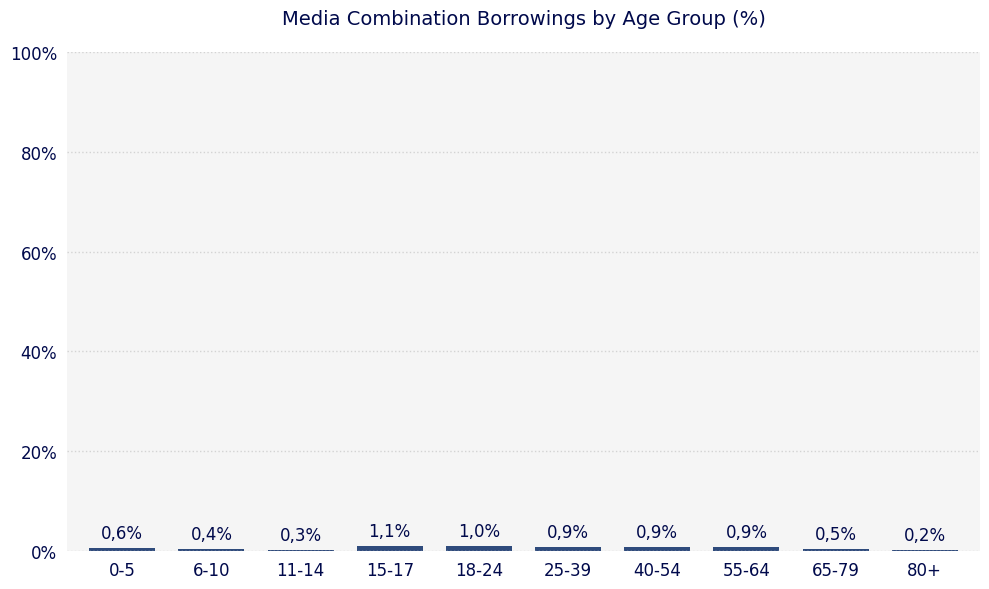

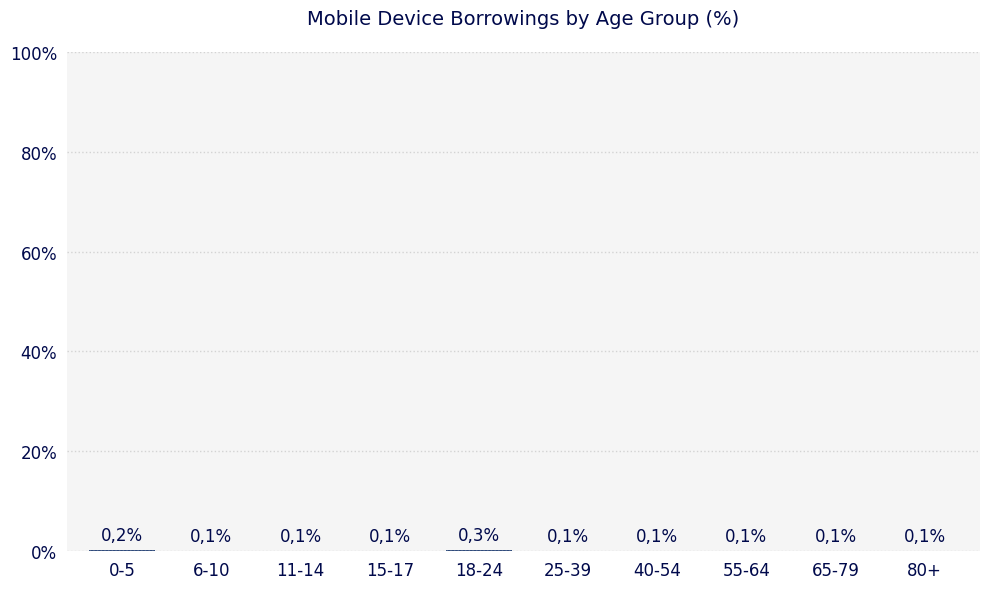

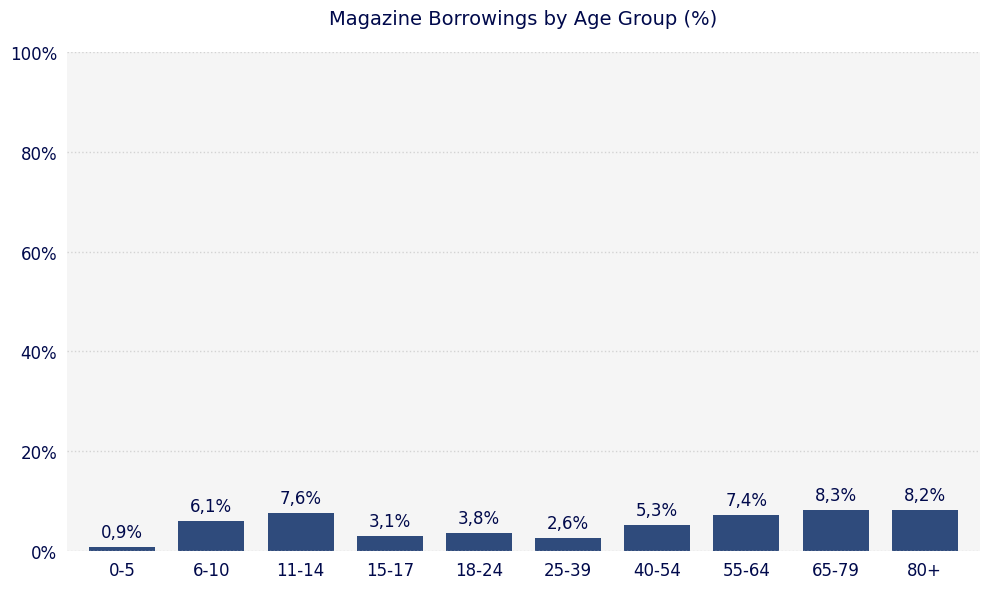

In [236]:
# Define media types of interest as variable
media_types = ["Book", "CD", "DVD", "Console Game", "Conventional Game", "Media Combination", "Mobile Device", "Magazine"]

# Compute relative borrowings by media type across each age group
media_by_age_df = pd.crosstab(loans_df["Age Group"], loans_df["Media Type"], normalize='index') * 100

# Retain only media types that exist in the dataset and order rows by age group
existing_media_types = [m for m in media_types if m in media_by_age_df.columns]
media_by_age_df = media_by_age_df[existing_media_types].reindex(age_order)

# Plot one bar chart per media type, showing relative borrowing by age group
text_color = "#00094B"
for media in existing_media_types:
    fig, ax = plt.subplots(figsize=(10, 6))
    media_by_age_df[media].plot(
        kind="bar",
        color="#2f4b7c",
        ax=ax,
        width=0.74
    )

    # Annotate bars with percentage values
    for i, (label, percent) in enumerate(media_by_age_df[media].items()):
        if pd.notna(percent):
            ax.text(
                i,
                percent + 1.2,
                f"{percent:.1f}%".replace(".", ","),
                ha='center',
                va='bottom',
                color=text_color,
                fontsize=12
            )

    # Configure y-axis as percentage scale
    ax.set_ylim(0, media_by_age_df[media].max() * 1.3)
    ax.set_yticks(range(0, 101, 20))
    ax.set_yticklabels([f"{x}%" for x in range(0, 101, 20)], fontsize=12, color=text_color)

    # Format x-axis with age group labels
    ax.set_xticklabels(media_by_age_df.index, rotation=0, fontsize=12, color=text_color)

    # Set title and remove axis labels for cleaner layout
    ax.set_title(f"{media} Borrowings by Age Group (%)", fontsize=14, color=text_color, pad=20)
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Style: remove frame and add grid
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_facecolor("#f5f5f5")
    ax.grid(axis='y', which='major', linestyle='dotted', color='lightgray', linewidth=1)
    ax.tick_params(left=False, bottom=False)

    # Final layout adjustment
    plt.tight_layout()
    plt.show()

#### <u>Tables  22-30 </u> Borrowings by Age Group and Media Types

/var/folders/69/0fc8h_h95kv8k6fx2shn5p440000gn/T/ipykernel_36601/1617428973.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


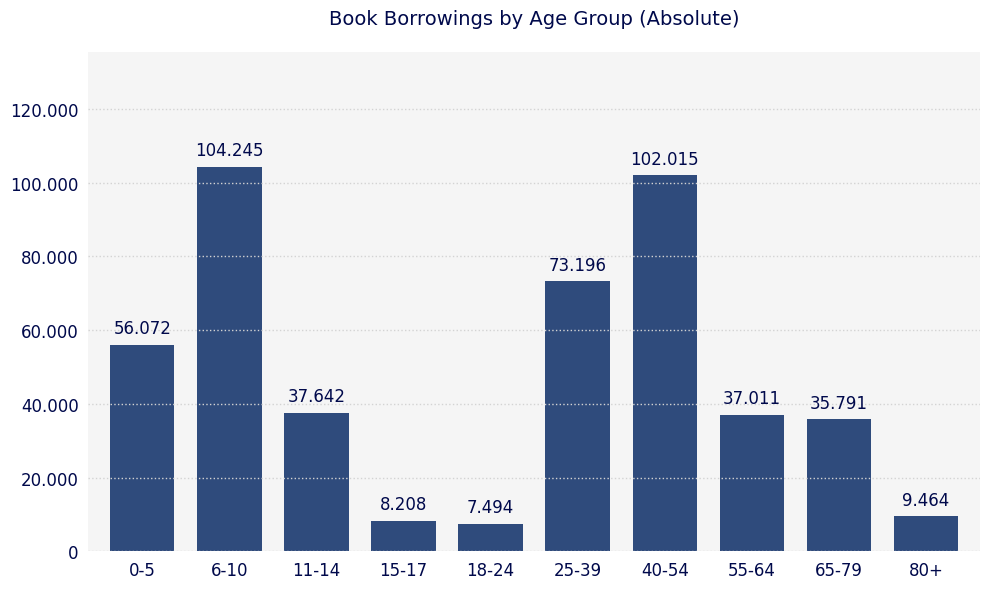

/var/folders/69/0fc8h_h95kv8k6fx2shn5p440000gn/T/ipykernel_36601/1617428973.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


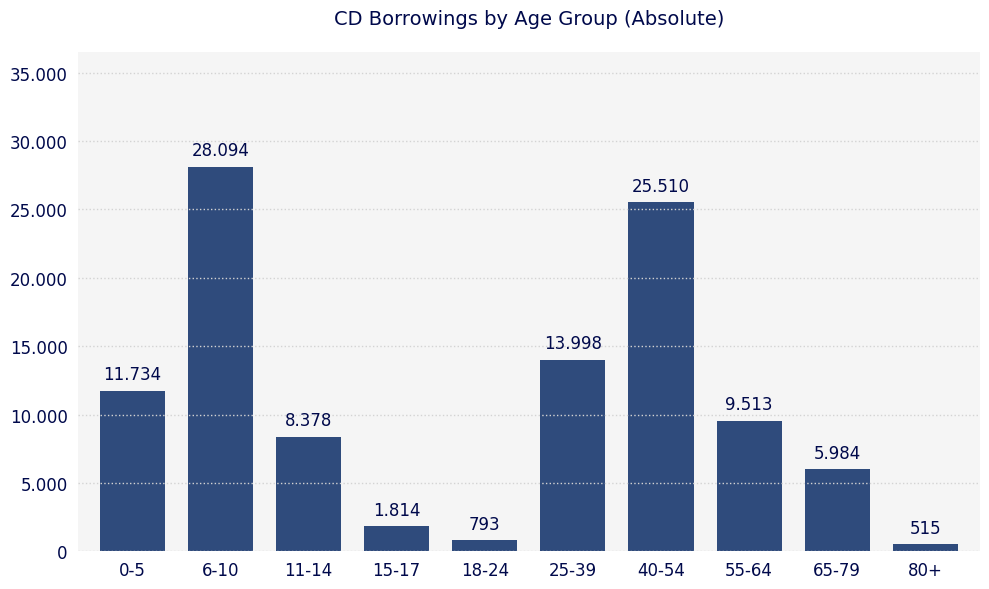

/var/folders/69/0fc8h_h95kv8k6fx2shn5p440000gn/T/ipykernel_36601/1617428973.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


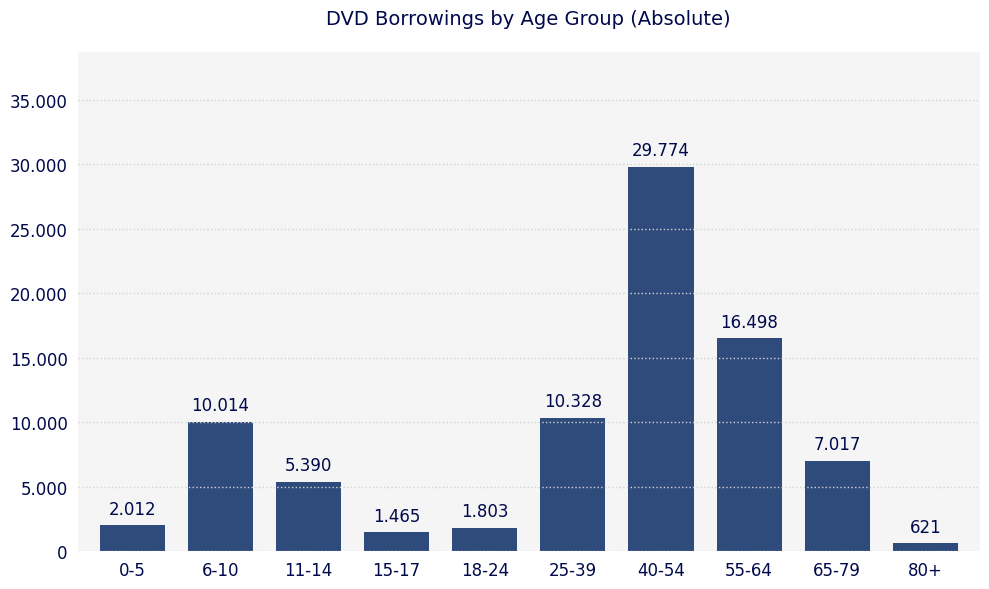

/var/folders/69/0fc8h_h95kv8k6fx2shn5p440000gn/T/ipykernel_36601/1617428973.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


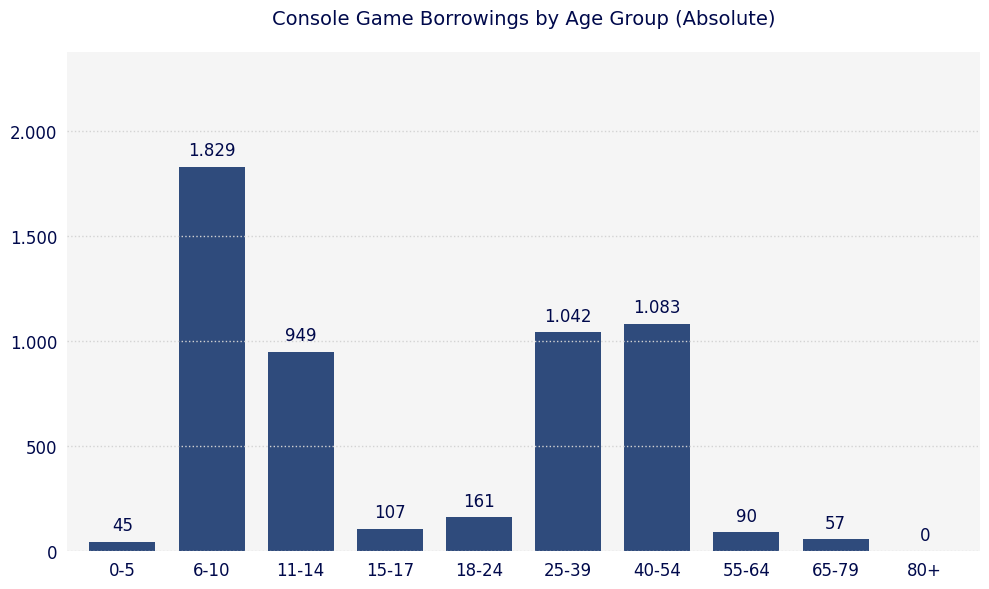

/var/folders/69/0fc8h_h95kv8k6fx2shn5p440000gn/T/ipykernel_36601/1617428973.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


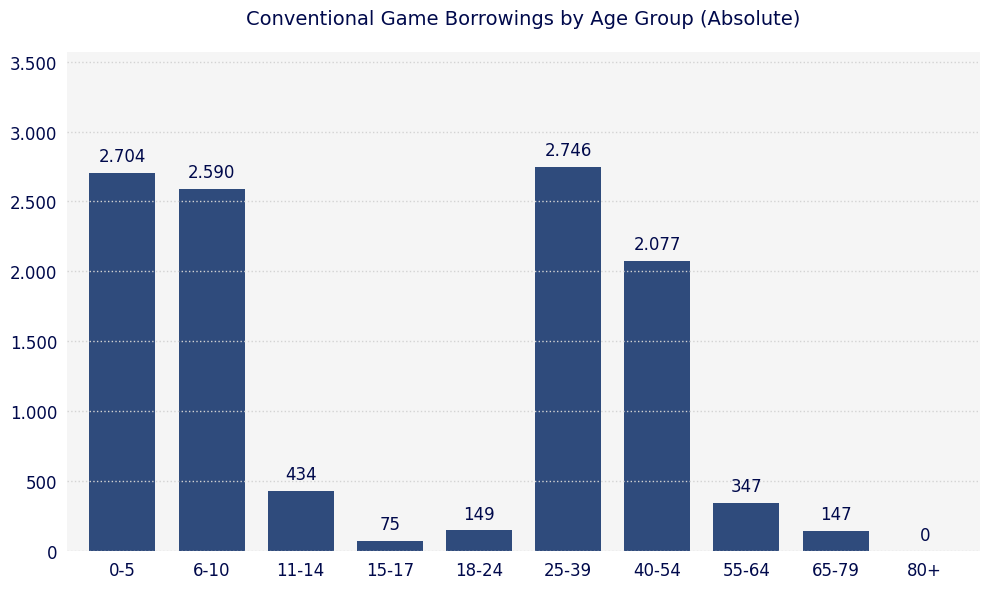

/var/folders/69/0fc8h_h95kv8k6fx2shn5p440000gn/T/ipykernel_36601/1617428973.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


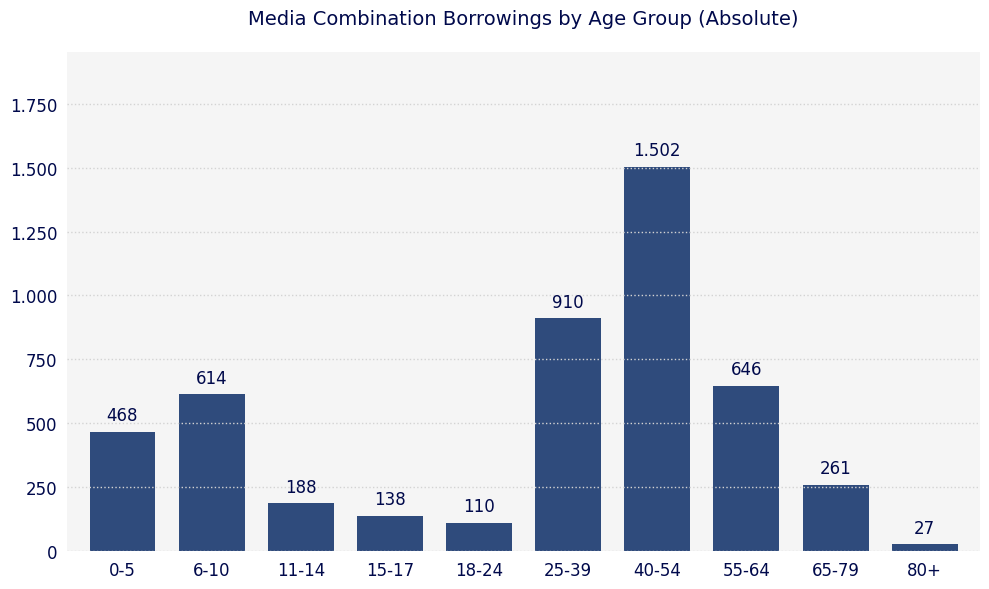

/var/folders/69/0fc8h_h95kv8k6fx2shn5p440000gn/T/ipykernel_36601/1617428973.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


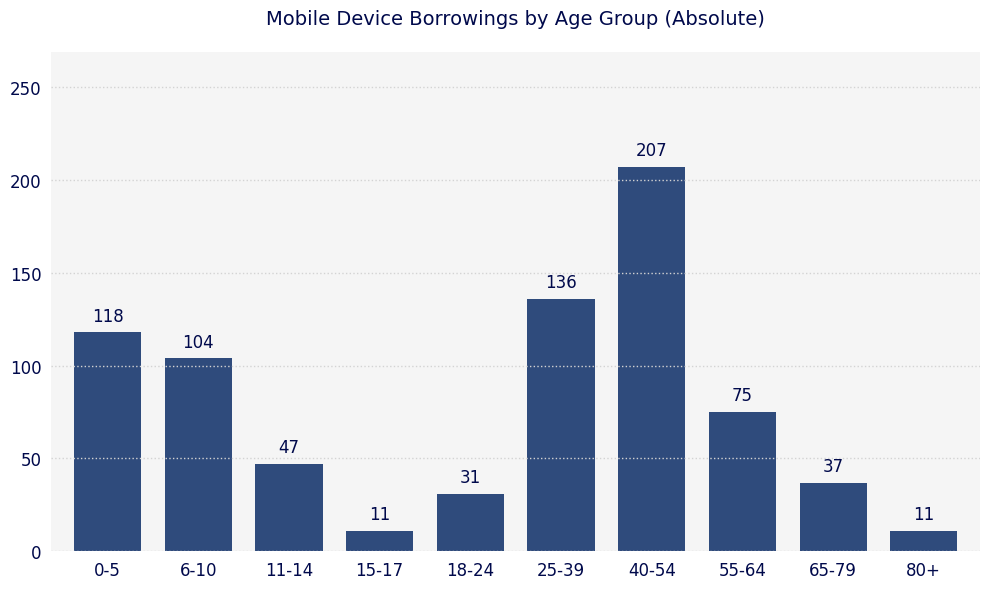

/var/folders/69/0fc8h_h95kv8k6fx2shn5p440000gn/T/ipykernel_36601/1617428973.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


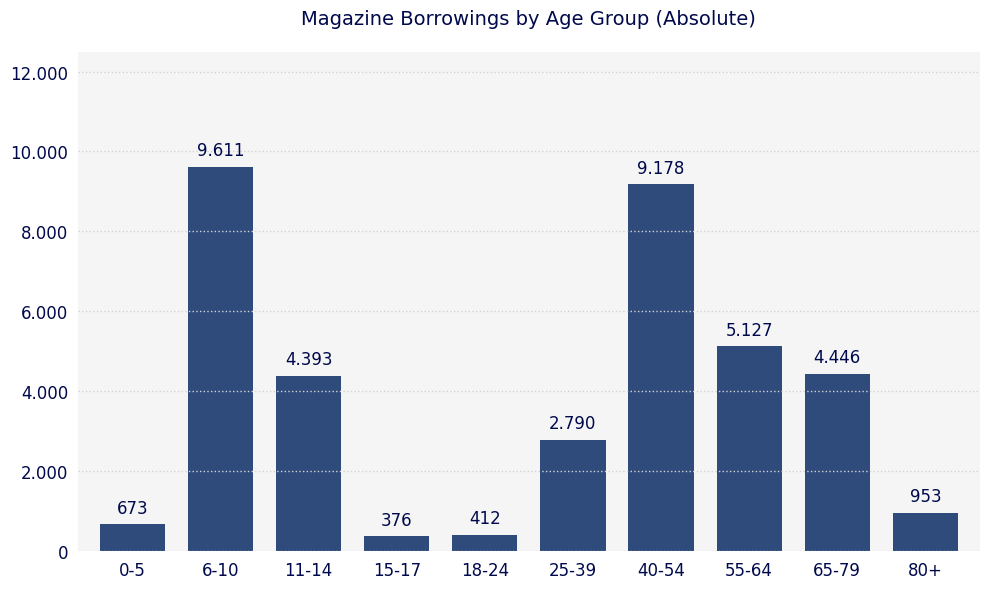

In [237]:
# Define media types of interest
media_types = ["Book", "CD", "DVD", "Console Game", "Conventional Game", "Media Combination", "Mobile Device", "Magazine"]

# Crosstab: absolute borrow counts 
media_by_age_df_abs = pd.crosstab(loans_df["Age Group"], loans_df["Media Type"])

# Keep only selected media types that exist in the data
existing_media_types = [m for m in media_types if m in media_by_age_df_abs.columns]
media_by_age_df_abs = media_by_age_df_abs[existing_media_types].reindex(age_order)

# Styling and plot per media type
text_color = "#00094B"
for media in existing_media_types:
    fig, ax = plt.subplots(figsize=(10, 6))
    media_by_age_df_abs[media].plot(
        kind="bar",
        color="#2f4b7c",
        ax=ax,
        width=0.74
    )

    # Add value labels on top
    for i, (label, value) in enumerate(media_by_age_df_abs[media].items()):
        if pd.notna(value):
            ax.text(
                i,
                value + max(media_by_age_df_abs[media]) * 0.02,
                f"{int(value):,}".replace(",", "."),
                ha='center',
                va='bottom',
                color=text_color,
                fontsize=12
            )

    # Axis styling
    ax.set_ylim(0, media_by_age_df_abs[media].max() * 1.3)
    ax.set_yticklabels(
        [f"{int(y):,}".replace(",", ".") for y in ax.get_yticks()],
        fontsize=12,
        color=text_color
    )
    ax.set_xticklabels(media_by_age_df_abs.index, rotation=0, fontsize=12, color=text_color)

    ax.set_title(f"{media} Borrowings by Age Group (Absolute)", fontsize=14, color=text_color, pad=20)
    ax.set_xlabel("")
    ax.set_ylabel("")

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_facecolor("#f5f5f5")
    ax.grid(axis='y', which='major', linestyle='dotted', color='lightgray', linewidth=1)
    ax.tick_params(left=False, bottom=False)

    plt.tight_layout()
    plt.show()

## 3.5. Key Finding 4: Youth Disengagement is a Systemic Challenge Across the District

* The share of borrowings among youth is consistently low across all Pankow libraries. This suggests that youth disengagement is not a localized problem but a systemic challenge shared across the district. None of the eight libraries appears to specialize in or effectively attract young users.
  
* This lack of targeted youth engagement stands in contrast to other age groups, particularly early childhood (0–5), where some libraries show stronger specialization. One such example is the Kurt-Tucholsky-Bibliothek, which has a significantly higher share of borrowings from the 0–5 age group compared to other branches. This demonstrates that age-specific outreach and design can be successful.


#### <u>Table  18</u> Borrowings by Age Group and Library: Relative Frequencies


In [238]:
#Create normalized crosstab
rel_freq_table = pd.crosstab(
    loans_df["Age Group"],
    loans_df["Library"],
    normalize='columns'
) * 100

#Reset index so 'Age Group' is a column
rel_freq_table = rel_freq_table.reset_index()

#Define row-highlights
highlight_rows = ["11-14", "15-17", "18-24"]

#Define custom styling function
def custom_highlight(row):
    styles = [''] * len(row)
    
    # Highlight entire row
    if row["Age Group"] in highlight_rows:
        styles = ['background-color: #9dc6e0'] * len(row)

    # Highlight specific cell
    if row["Age Group"] == "0-5":
        for idx, col in enumerate(row.index):
            if col == "Kurt-Tucholsky-Bibliothek":
                styles[idx] = 'background-color: #c1e7ff'

    return styles

# Format style
styled_table = rel_freq_table.style \
    .hide(axis="index") \
    .apply(custom_highlight, axis=1) \
    .format({col: "{:.1f}%" for col in rel_freq_table.columns if col != "Age Group"})\
    .set_properties(**{
        'color': '#00094B',
        'text-align': 'left'
    }) \
    .set_table_styles([
        {
            'selector': 'th',
            'props': [
                ('color', '#00094B'),
                ('text-align', 'left'),
                ('padding', '6px'),
                ('font-size', '12px')
            ]
        }
    ])

# Display
styled_table

Age Group,Heinrich-Böll-Bibliothek,Janusz-Korczak-Bibliothek,Stadtteilbibliothek Buch-Karow (Buch),Wolfdietrich-Schnurre-Bibliothek,Stadtteilbibliothek Buch-Karow (Karow),Bettina-von-Arnim-Bibliothek,Kurt-Tucholsky-Bibliothek,Bibliothek Am Wasserturm
0-5,5.4%,9.7%,7.2%,8.0%,13.5%,10.3%,19.9%,13.0%
6-10,13.3%,19.7%,16.5%,20.5%,33.6%,26.8%,27.8%,22.7%
11-14,6.8%,7.9%,5.7%,7.8%,9.8%,9.8%,7.1%,7.6%
15-17,2.6%,1.5%,1.2%,2.1%,0.9%,1.7%,1.1%,1.5%
18-24,1.5%,1.4%,1.9%,2.7%,0.9%,1.3%,1.0%,1.2%
25-39,14.5%,15.0%,19.6%,15.0%,12.9%,13.4%,12.7%,14.4%
40-54,28.5%,23.3%,22.5%,22.8%,12.7%,26.6%,22.9%,23.8%
55-64,14.7%,10.1%,8.2%,12.2%,4.5%,6.8%,4.8%,9.3%
65-79,9.5%,9.4%,13.2%,7.5%,9.2%,3.1%,2.7%,5.9%
80+,3.1%,2.2%,4.1%,1.3%,2.0%,0.3%,0.1%,0.6%
